In [2]:
#Import the data
import pandas as pd
#%pip install openpyxl


# Assuming 'data.xlsx' is your Excel file name in the Downloads folder, adjust the path accordingly
excel_file_path = '/Users/katherinecole/Downloads/Oncology_IO Data.xlsx'

# Read the Excel file into a Pandas dataframe
df = pd.read_excel(excel_file_path)

# Print the first 5 rows of the dataframe
print(df.head())



     ID   Cohort  Year of ICI treatment start Age at ICI start     Sex  \
0  8213  Initial                         2017          61 - 65  Female   
1  8214  Initial                         2018          66 - 70  Female   
2  8215  Initial                         2018          61 - 65  Female   
3  8216  Initial                         2015          56 - 60  Female   
4  8217  Initial                         2018          51 - 55  Female   

   Cancer type   NLR  MSI type  TMB (Mutations/Mb) ICI drug class  \
0   Colorectal  7.60       NaN                 4.9     PD-1/PD-L1   
1  Endometrial  1.19  Unstable                32.5     PD-1/PD-L1   
2         SCLC  1.38    Stable                19.3     PD-1/PD-L1   
3     Melanoma  2.69    Stable                 1.0          Combo   
4        NSCLC  2.54    Stable                10.5     PD-1/PD-L1   

  Best Response Response to ICI Clinical Benefit with ICI Progression  \
0            PD              No                        No         Y

In [3]:
#Quick Descriptive statistics- We had already explored the data in assignment #2, so I did not do a comprehensive exploratory analysis

#Get list of column name
print(df.columns. values. tolist())

#Identify number of rows and columns
print(df.shape)

['ID', 'Cohort', 'Year of ICI treatment start', 'Age at ICI start', 'Sex', 'Cancer type', 'NLR', 'MSI type', 'TMB (Mutations/Mb)', 'ICI drug class', 'Best Response', 'Response to ICI', 'Clinical Benefit with ICI', 'Progression', 'Progression-Free Survival (Months)', 'Vital status', 'Overall Survival (Months)', 'Stage at ICI start', 'ICI line of treatment', 'ECOG PS']
(2037, 20)


In [4]:
#Identify column types
column_types = df.dtypes
print(column_types)

#Assess for missing values, and make sure missing values are identified correctly

missing_values = df.isnull().sum()
print(missing_values)

ID                                      int64
Cohort                                 object
Year of ICI treatment start             int64
Age at ICI start                       object
Sex                                    object
Cancer type                            object
NLR                                   float64
MSI type                               object
TMB (Mutations/Mb)                    float64
ICI drug class                         object
Best Response                          object
Response to ICI                        object
Clinical Benefit with ICI              object
Progression                            object
Progression-Free Survival (Months)    float64
Vital status                           object
Overall Survival (Months)             float64
Stage at ICI start                     object
ICI line of treatment                  object
ECOG PS                               float64
dtype: object
ID                                      0
Cohort                  

In [5]:
df.info() #This is another way to view the number of non-missing values, and to get the Dtype for the column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2037 entries, 0 to 2036
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  2037 non-null   int64  
 1   Cohort                              2037 non-null   object 
 2   Year of ICI treatment start         2037 non-null   int64  
 3   Age at ICI start                    2037 non-null   object 
 4   Sex                                 2037 non-null   object 
 5   Cancer type                         2037 non-null   object 
 6   NLR                                 2037 non-null   float64
 7   MSI type                            1691 non-null   object 
 8   TMB (Mutations/Mb)                  2037 non-null   float64
 9   ICI drug class                      2037 non-null   object 
 10  Best Response                       2037 non-null   object 
 11  Response to ICI                     2037 no

In [6]:
#Use my clean_names function here

import re

def clean_names(x):
    #replace all variable names to lowercase
    x = x.lower()
    # Replace any character NOT alphanumeric with underscore
    x = re.sub(r'[^a-zA-Z0-9]', '_', x)
    # Replace two or more underscores with a single underscore
    x = re.sub(r'_{2,}', '_', x)
    # Replace any non-alphabetic character at the beginning with empty string
    x = re.sub(r'^[^a-zA-Z]+', '', x)
    # Replace any non-alphanumeric character at the end with empty string
    x = re.sub(r'[^a-zA-Z0-9]+$', '', x)
    return x

# Function to clean column names
def clean_column_names(df):
    df.columns = [clean_names(col) for col in df.columns]
    return df

# Clean column names
data_clean = clean_column_names(df)

# Now the column names will be cleaned
print(data_clean.columns)


Index(['id', 'cohort', 'year_of_ici_treatment_start', 'age_at_ici_start',
       'sex', 'cancer_type', 'nlr', 'msi_type', 'tmb_mutations_mb',
       'ici_drug_class', 'best_response', 'response_to_ici',
       'clinical_benefit_with_ici', 'progression',
       'progression_free_survival_months', 'vital_status',
       'overall_survival_months', 'stage_at_ici_start',
       'ici_line_of_treatment', 'ecog_ps'],
      dtype='object')


In [7]:
data_clean = data_clean.rename(columns={
        'year_of_ici_treatment_start': 'tx_year', 
        'progression_free_survival_months': 'PFS', 
        'overall_survival_months': 'OS',
        'clinical_benefit_with_ici': 'clin_benefit',
        'age_at_ici_start': 'age',
        'ici_drug_class': 'drug_class',
        'response_to_ici': 'response',
        'stage_at_ici_start': 'stage',
        'ecog_ps': 'ECOG',
        'ici_line_of_treatment': 'tx_line'
})
print(data_clean.columns)


Index(['id', 'cohort', 'tx_year', 'age', 'sex', 'cancer_type', 'nlr',
       'msi_type', 'tmb_mutations_mb', 'drug_class', 'best_response',
       'response', 'clin_benefit', 'progression', 'PFS', 'vital_status', 'OS',
       'stage', 'tx_line', 'ECOG'],
      dtype='object')


In [8]:

#Print the number of unique levels per column

#We need to fix the alive variable as there are multiple versions of "alive"

object_columns = data_clean.select_dtypes(include=['object']).columns
for col in object_columns:
    unique_levels = data_clean[col].unique()
    print(f"Unique levels for column '{col}': {unique_levels}")

Unique levels for column 'cohort': ['Initial' 'Validation']
Unique levels for column 'age': ['61 - 65' '66 - 70' '56 - 60' '51 - 55' '71 - 75' '76 - 80' '91 - 95'
 '81 - 85' '86 - 90' '46 - 50' '36 - 40' '41 - 45' '21 - 25' '31 - 35'
 '26 - 30' '11 - 15' '16 - 20' '0 - 5' '6 - 10']
Unique levels for column 'sex': ['Female' 'Male']
Unique levels for column 'cancer_type': ['Colorectal' 'Endometrial' 'SCLC' 'Melanoma' 'NSCLC' 'Hepatobiliary'
 'Gastric' 'Pancreatic' 'Renal' 'Bladder' 'Sarcoma' 'Esophageal'
 'Head & Neck' 'Ovarian' 'Breast' 'Mesothelioma' 'CNS' 'Unknown primary']
Unique levels for column 'msi_type': [nan 'Unstable' 'Stable' 'Indeterminate']
Unique levels for column 'drug_class': ['PD-1/PD-L1' 'Combo' 'CTLA-4' 'combo']
Unique levels for column 'best_response': ['PD' 'PR' 'CR' 'SD']
Unique levels for column 'response': ['No' 'Yes']
Unique levels for column 'clin_benefit': ['No' 'Yes']
Unique levels for column 'progression': ['Yes' 'No']
Unique levels for column 'vital_status'

In [9]:
#Restrict analysis to adults only (exclud kids)
# Check for leading or trailing spaces in category levels
#print(data_clean['age'].unique())

# Now, try excluding the categories again

excluded_categories_age = ['0 - 5', '6 - 10', '11 - 15', '16 - 20']
data_clean1 = data_clean[~data_clean['age'].isin(excluded_categories_age)]
#print(data_clean2)

excluded_categories_cancer = ['Endometrial', 'Sarcoma', 'Head & Neck', 'Ovarian', 'Mesothelioma', 'CNS', 'Unknown primary']
data_clean2 = data_clean1[~data_clean1['cancer_type'].isin(excluded_categories_cancer)]

unique_levels2 = data_clean2['age'].unique()
print(unique_levels2)

unique_levels2 = data_clean2['cancer_type'].unique()
print(unique_levels2)


['61 - 65' '56 - 60' '51 - 55' '66 - 70' '71 - 75' '76 - 80' '81 - 85'
 '86 - 90' '46 - 50' '36 - 40' '41 - 45' '21 - 25' '26 - 30' '31 - 35'
 '91 - 95']
['Colorectal' 'SCLC' 'Melanoma' 'NSCLC' 'Hepatobiliary' 'Gastric'
 'Pancreatic' 'Renal' 'Bladder' 'Esophageal' 'Breast']


In [10]:


# Define the mapping from old categories to new categories
mapping_age = {'21 - 25': '21 - 30', '26 - 30': '21 - 30', '31 - 35': '31 - 40', 
           '36 - 40': '31 - 40', '41 - 45': '41 - 50', '46 - 50': '41 - 50',
           '51 - 55': '51 - 60', '56 - 60': '51 - 60',
           '61 - 65': '61 - 70', '66 - 70': '61 - 70',
           '71 - 75': '71 - 95', '76 - 80': '71 - 95', '81 - 85': '71 - 95', '86 - 90': '71 - 95', '91 - 95': '71 - 95'}

# Regroup the categorical variable using the mapping
data_clean2['age'] = data_clean2['age'].replace(mapping_age)

mapping_cancer = { 'Colorectal':'LGI',
                  'Endometrial': 'Gyne',
                  'SCLC': 'Lung',
                  'Melanoma': 'Melanoma',
                  'Hepatobiliary': 'UGI',
                  'NSCLC': 'Lung',
                  'Gastric': 'UGI',
                  'Pancreatic': 'UGI',
                  'Renal': 'GU',
                  'Bladder': 'GU',
                  'Sarcoma': 'Sarcoma',
                  'Esophageal': 'UGI',
                  'Head & Neck': 'HNC',
                  'Ovarian': 'Gyne',
                  'Breast': 'Breast',
                  'Mesothelioma': 'Mesothelioma',
                  'CNS': 'CNS',
                  'Unknown primary': 'CUP'
                  
    
}

mapping_cancer2 = { 'Colorectal':'LGI',
                  #'Endometrial': 'Gyne',
                  'SCLC': 'Lung',
                  'Melanoma': 'Melanoma',
                  'Hepatobiliary': 'UGI',
                  'NSCLC': 'Lung',
                  'Gastric': 'UGI',
                  'Pancreatic': 'UGI',
                  'Renal': 'GU',
                  'Bladder': 'GU',
                  #'Sarcoma': 'Sarcoma',
                  'Esophageal': 'UGI',
                  #'Head & Neck': 'HNC',
                  #'Ovarian': 'Gyne',
                  'Breast': 'Breast',
                 # 'Mesothelioma': 'Mesothelioma',
                  #'CNS': 'CNS',
                  #'Unknown primary': 'CUP'
                  
    
}



data_clean2['cancer_type'] = data_clean2['cancer_type'].replace(mapping_cancer2)

print(data_clean2)

unique_levels2 = data_clean2['age'].unique()
unique_levels2 = data_clean2['cancer_type'].unique()
print(unique_levels2)



         id      cohort  tx_year      age     sex cancer_type    nlr msi_type  \
0      8213     Initial     2017  61 - 70  Female         LGI   7.60      NaN   
2      8215     Initial     2018  61 - 70  Female        Lung   1.38   Stable   
3      8216     Initial     2015  51 - 60  Female    Melanoma   2.69   Stable   
4      8217     Initial     2018  51 - 60  Female        Lung   2.54   Stable   
5      8218     Initial     2017  61 - 70  Female         UGI   3.32      NaN   
...     ...         ...      ...      ...     ...         ...    ...      ...   
2030  10539  Validation     2018  51 - 60  Female          GU   3.60   Stable   
2033  10542  Validation     2019  41 - 50    Male          GU   2.39   Stable   
2034  10543  Validation     2019  41 - 50    Male          GU   1.46   Stable   
2035  10544  Validation     2019  31 - 40    Male          GU   2.40   Stable   
2036  10545  Validation     2019  61 - 70  Female          GU  14.00   Stable   

      tmb_mutations_mb  dru

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/1902349933.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean2['age'] = data_clean2['age'].replace(mapping_age)
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/1902349933.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean2['cancer_type'] = data_clean2['cancer_type'].replace(mapping_cancer2)


In [98]:
column_names = data_clean2.columns.tolist()

print(column_names)


['id', 'cohort', 'tx_year', 'age', 'sex', 'cancer_type', 'nlr', 'msi_type', 'tmb_mutations_mb', 'drug_class', 'best_response', 'response', 'clin_benefit', 'progression', 'PFS', 'vital_status', 'OS', 'stage', 'tx_line', 'ECOG']


In [11]:
# List of categorical variables to summarize

#Note that the age variables are not grouped together
categorical_variables = ['age', 'progression', 'vital_status', 'drug_class','msi_type','best_response', 'response', 'clin_benefit','stage','tx_line', 'sex', 'cancer_type']

# Generate summary tables for each categorical variable
summary_tables = {}
for variable in categorical_variables:
    summary_table = data_clean2[variable].value_counts().reset_index()
    summary_table.columns = [variable, 'Count']
    summary_tables[variable] = summary_table

# Print summary tables
for variable, table in summary_tables.items():
    print(f"\nSummary table for '{variable}':")
    print(table)

#NOTE, ECOG was not included, getting an error, need to sort that out!


Summary table for 'age':
       age  Count
0  61 - 70    548
1  71 - 95    411
2  51 - 60    368
3  41 - 50    160
4  31 - 40     67
5  21 - 30     23

Summary table for 'progression':
  progression  Count
0         Yes   1296
1          No    281

Summary table for 'vital_status':
  vital_status  Count
0         Dead    923
1        Alive    626
2        ALIVE     27
3       Alive       1

Summary table for 'drug_class':
   drug_class  Count
0  PD-1/PD-L1   1293
1       Combo    253
2       combo     25
3      CTLA-4      6

Summary table for 'msi_type':
        msi_type  Count
0         Stable   1229
1  Indeterminate     48
2       Unstable     33

Summary table for 'best_response':
  best_response  Count
0            PD    770
1            SD    361
2            PR    352
3            CR     94

Summary table for 'response':
  response  Count
0       No   1131
1      Yes    446

Summary table for 'clin_benefit':
  clin_benefit  Count
0           No   1016
1          Yes    561

Sum

In [12]:

#colate 'vital_status' values
data_clean2['vital_status'] = data_clean2['vital_status'].str.lower().replace({'alive ': 'alive', 'alive': 'alive'})

# Generate summary table for 'vital_status'
summary_table = data_clean2['vital_status'].value_counts().reset_index()
summary_table.columns = ['vital_status', 'Count']

print(summary_table)


#colate 'drug class' values
data_clean2['drug_class'] = data_clean2['drug_class'].str.lower().replace({'combo': 'Combo'})

# Generate summary table for 'vital_status'
summary_table = data_clean2['drug_class'].value_counts().reset_index()
summary_table.columns = ['drug_class', 'Count']

print(summary_table)




  vital_status  Count
0         dead    923
1        alive    654
   drug_class  Count
0  pd-1/pd-l1   1293
1       Combo    278
2      ctla-4      6


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/1178521080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean2['vital_status'] = data_clean2['vital_status'].str.lower().replace({'alive ': 'alive', 'alive': 'alive'})
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/1178521080.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean2['drug_class'] = data_clean2['drug_class'].str.lower().replace({'combo': 'Combo'})


In [102]:

#Split into train and test dataframe

test_size = int(0.15 * len(data_clean2))

# Shuffle the indices
indices = np.arange(len(data_clean2))
np.random.shuffle(indices)

# Split indices into training and testing sets
train_df = data_clean2.iloc[:-test_size]
test_df = data_clean2.iloc[-test_size:]
display(train_df)
display(test_df)


,id,cohort,tx_year,age,sex,cancer_type,nlr,msi_type,tmb_mutations_mb,drug_class,best_response,response,clin_benefit,progression,PFS,vital_status,OS,stage,tx_line,ECOG
0,8213,Initial,2017,61 - 70,Female,LGI,7.60,NaN,4.9,pd-1/pd-l1,PD,No,No,Yes,0.92,dead,5.62,IV,Subsequent-line,0.0
2,8215,Initial,2018,61 - 70,Female,Lung,1.38,Stable,19.3,pd-1/pd-l1,PR,Yes,Yes,Yes,3.45,alive,9.59,IV,Subsequent-line,0.0
3,8216,Initial,2015,51 - 60,Female,Melanoma,2.69,Stable,1.0,Combo,PD,No,No,Yes,0.56,alive,50.14,IV,First-line,0.0
4,8217,Initial,2018,51 - 60,Female,Lung,2.54,Stable,10.5,pd-1/pd-l1,PR,Yes,Yes,Yes,4.67,alive,9.99,IV,Subsequent-line,0.0
5,8218,Initial,2017,61 - 70,Female,UGI,3.32,NaN,6.1,pd-1/pd-l1,PD,No,No,Yes,1.91,dead,6.05,IV,Subsequent-line,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626,10027,Initial,2018,61 - 70,Male,Lung,6.50,Stable,12.3,pd-1/pd-l1,SD,No,Yes,No,11.70,alive,12.22,III,Subsequent-line,1.0
1627,10028,Initial,2018,71 - 95,Male,Lung,4.82,Stable,9.7,pd-1/pd-l1,PD,No,No,Yes,1.54,dead,1.54,IV,First-line,1.0
1628,10029,Initial,2018,71 - 95,Female,Lung,4.77,Stable,7.0,pd-1/pd-l1,PR,Yes,Yes,No,14.69,alive,15.41,IV,First-line,NaN
1629,10030,Initial,2018,51 - 60,Male,Lung,4.92,Stable,3.5,pd-1/pd-l1,SD,No,Yes,Yes,8.08,alive,14.95,IV,First-line,0.0


,id,cohort,tx_year,age,sex,cancer_type,nlr,msi_type,tmb_mutations_mb,drug_class,best_response,response,clin_benefit,progression,PFS,vital_status,OS,stage,tx_line,ECOG
1631,10033,Initial,2018,51 - 60,Female,Lung,2.33,Stable,8.8,pd-1/pd-l1,SD,No,Yes,Yes,7.03,alive,11.99,III,Subsequent-line,1.0
1632,10034,Initial,2018,71 - 95,Female,GU,1.79,Stable,8.8,pd-1/pd-l1,PR,Yes,Yes,No,11.93,alive,12.06,IV,Subsequent-line,0.0
1633,10035,Initial,2018,71 - 95,Female,Lung,6.00,Stable,14.9,pd-1/pd-l1,PR,Yes,Yes,No,11.96,alive,12.48,III,Subsequent-line,1.0
1635,10037,Initial,2018,61 - 70,Female,Lung,2.53,Stable,7.9,pd-1/pd-l1,PD,No,No,Yes,1.35,alive,15.90,IV,First-line,1.0
1636,10038,Initial,2018,61 - 70,Male,Melanoma,7.00,Stable,17.6,Combo,PR,Yes,Yes,Yes,2.60,alive,7.85,III,First-line,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,10539,Validation,2018,51 - 60,Female,GU,3.60,Stable,2.6,Combo,SD,No,No,Yes,1.38,dead,9.86,IV,First-line,1.0
2033,10542,Validation,2019,41 - 50,Male,GU,2.39,Stable,4.4,Combo,PD,No,No,Yes,2.63,alive,13.31,IV,First-line,0.0
2034,10543,Validation,2019,41 - 50,Male,GU,1.46,Stable,2.6,pd-1/pd-l1,SD,No,Yes,Yes,10.48,dead,10.48,IV,First-line,0.0
2035,10544,Validation,2019,31 - 40,Male,GU,2.40,Stable,2.6,Combo,PD,No,No,Yes,3.22,alive,10.51,III,First-line,0.0


In [95]:

#Come back to examine this


cohort_initial = data_clean2[data_clean2['cohort'].isin(['Initial'])]
cohort_val = data_clean2[data_clean2['cohort'].isin(['Validation'])]

display(cohort_initial)
display(cohort_val)



,id,cohort,tx_year,age,sex,cancer_type,nlr,msi_type,tmb_mutations_mb,drug_class,best_response,response,clin_benefit,progression,PFS,vital_status,OS,stage,tx_line,ECOG
0,8213,Initial,2017,61 - 70,Female,LGI,7.60,NaN,4.9,pd-1/pd-l1,PD,No,No,Yes,0.92,dead,5.62,IV,Subsequent-line,0.0
2,8215,Initial,2018,61 - 70,Female,Lung,1.38,Stable,19.3,pd-1/pd-l1,PR,Yes,Yes,Yes,3.45,alive,9.59,IV,Subsequent-line,0.0
3,8216,Initial,2015,51 - 60,Female,Melanoma,2.69,Stable,1.0,Combo,PD,No,No,Yes,0.56,alive,50.14,IV,First-line,0.0
4,8217,Initial,2018,51 - 60,Female,Lung,2.54,Stable,10.5,pd-1/pd-l1,PR,Yes,Yes,Yes,4.67,alive,9.99,IV,Subsequent-line,0.0
5,8218,Initial,2017,61 - 70,Female,UGI,3.32,NaN,6.1,pd-1/pd-l1,PD,No,No,Yes,1.91,dead,6.05,IV,Subsequent-line,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709,10297,Initial,2018,61 - 70,Male,Melanoma,8.71,Stable,8.8,Combo,SD,No,No,Yes,2.37,alive,4.07,IV,First-line,0.0
1710,10124,Initial,2018,61 - 70,Male,UGI,1.87,Stable,8.8,pd-1/pd-l1,SD,No,Yes,Yes,8.61,alive,8.77,IV,First-line,0.0
1711,10125,Initial,2018,71 - 95,Female,Lung,11.13,Stable,4.4,pd-1/pd-l1,SD,No,No,No,7.56,alive,7.66,IV,First-line,0.0
1712,10126,Initial,2018,51 - 60,Female,Lung,4.40,Stable,2.6,pd-1/pd-l1,PR,Yes,Yes,Yes,6.77,alive,10.68,IV,First-line,0.0


,id,cohort,tx_year,age,sex,cancer_type,nlr,msi_type,tmb_mutations_mb,drug_class,best_response,response,clin_benefit,progression,PFS,vital_status,OS,stage,tx_line,ECOG
1714,10326,Validation,2016,51 - 60,Male,GU,2.44,Stable,5.9,pd-1/pd-l1,PR,Yes,Yes,No,42.78,alive,42.78,IV,First-line,1.0
1718,10329,Validation,2019,71 - 95,Female,GU,2.00,Stable,3.5,pd-1/pd-l1,SD,No,Yes,No,10.12,alive,10.12,IV,Subsequent-line,1.0
1719,10330,Validation,2018,51 - 60,Male,GU,1.14,Stable,5.3,pd-1/pd-l1,PD,No,No,Yes,2.66,alive,22.54,IV,Subsequent-line,0.0
1721,10331,Validation,2014,71 - 95,Female,GU,7.00,Stable,6.9,pd-1/pd-l1,SD,No,No,Yes,3.98,dead,13.24,IV,Subsequent-line,1.0
1723,10333,Validation,2019,51 - 60,Female,GU,2.87,Stable,2.6,pd-1/pd-l1,SD,No,No,Yes,2.96,dead,10.68,IV,Subsequent-line,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,10539,Validation,2018,51 - 60,Female,GU,3.60,Stable,2.6,Combo,SD,No,No,Yes,1.38,dead,9.86,IV,First-line,1.0
2033,10542,Validation,2019,41 - 50,Male,GU,2.39,Stable,4.4,Combo,PD,No,No,Yes,2.63,alive,13.31,IV,First-line,0.0
2034,10543,Validation,2019,41 - 50,Male,GU,1.46,Stable,2.6,pd-1/pd-l1,SD,No,Yes,Yes,10.48,dead,10.48,IV,First-line,0.0
2035,10544,Validation,2019,31 - 40,Male,GU,2.40,Stable,2.6,Combo,PD,No,No,Yes,3.22,alive,10.51,III,First-line,0.0


In [103]:
from sksurv.preprocessing import OneHotEncoder

# Convert specific columns to categorical dtype

#I took out age here
columns_to_convert = ['response', 'clin_benefit', 'cancer_type', 'sex', 'cohort', 'drug_class', 'progression']  # List of columns to convert
train_df[columns_to_convert] = train_df[columns_to_convert].astype('category')

# Apply OneHotEncoder
encoder = OneHotEncoder()
data_encoded = encoder.fit_transform(train_df[columns_to_convert])

#print(data_encoded)

# Concatenate the encoded DataFrame with data_clean
data_clean_encoded = pd.concat([train_df.drop(columns=columns_to_convert), data_encoded], axis=1)

print(data_clean_encoded)

print(data_clean_encoded['vital_status'].unique())


         id  tx_year      age    nlr msi_type  tmb_mutations_mb best_response  \
0      8213     2017  61 - 70   7.60      NaN               4.9            PD   
2      8215     2018  61 - 70   1.38   Stable              19.3            PR   
3      8216     2015  51 - 60   2.69   Stable               1.0            PD   
4      8217     2018  51 - 60   2.54   Stable              10.5            PR   
5      8218     2017  61 - 70   3.32      NaN               6.1            PD   
...     ...      ...      ...    ...      ...               ...           ...   
1626  10027     2018  61 - 70   6.50   Stable              12.3            SD   
1627  10028     2018  71 - 95   4.82   Stable               9.7            PD   
1628  10029     2018  71 - 95   4.77   Stable               7.0            PR   
1629  10030     2018  51 - 60   4.92   Stable               3.5            SD   
1630  10032     2018  41 - 50  34.67   Stable               9.7            PD   

        PFS vital_status   

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/2258410782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns_to_convert] = train_df[columns_to_convert].astype('category')


In [14]:
data_clean_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1577 entries, 0 to 2036
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1577 non-null   int64  
 1   tx_year                1577 non-null   int64  
 2   age                    1577 non-null   object 
 3   nlr                    1577 non-null   float64
 4   msi_type               1310 non-null   object 
 5   tmb_mutations_mb       1577 non-null   float64
 6   best_response          1577 non-null   object 
 7   PFS                    1577 non-null   float64
 8   vital_status           1577 non-null   object 
 9   OS                     1577 non-null   float64
 10  stage                  1556 non-null   object 
 11  tx_line                1577 non-null   object 
 12  ECOG                   1455 non-null   float64
 13  response=Yes           1577 non-null   float64
 14  clin_benefit=Yes       1577 non-null   float64
 15  canc

In [104]:
#Need to decide on missing values

#Will do complete case analysis for now

data_complete = data_clean_encoded.dropna()
display(data_complete)
data_complete.info()

,id,tx_year,age,nlr,msi_type,tmb_mutations_mb,best_response,PFS,vital_status,OS,...,cancer_type=GU,cancer_type=LGI,cancer_type=Lung,cancer_type=Melanoma,cancer_type=UGI,sex=Male,cohort=Validation,drug_class=ctla-4,drug_class=pd-1/pd-l1,progression=Yes
2,8215,2018,61 - 70,1.38,Stable,19.3,PR,3.45,alive,9.59,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,8216,2015,51 - 60,2.69,Stable,1.0,PD,0.56,alive,50.14,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,8217,2018,51 - 60,2.54,Stable,10.5,PR,4.67,alive,9.99,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6,8219,2017,51 - 60,5.21,Stable,0.0,PR,8.61,dead,18.83,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
8,8221,2016,61 - 70,2.18,Indeterminate,2.0,PD,1.25,dead,2.33,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,10025,2018,51 - 60,9.25,Stable,0.0,PD,0.82,dead,0.82,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1626,10027,2018,61 - 70,6.50,Stable,12.3,SD,11.70,alive,12.22,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1627,10028,2018,71 - 95,4.82,Stable,9.7,PD,1.54,dead,1.54,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1629,10030,2018,51 - 60,4.92,Stable,3.5,SD,8.08,alive,14.95,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 2 to 1630
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     990 non-null    int64  
 1   tx_year                990 non-null    int64  
 2   age                    990 non-null    object 
 3   nlr                    990 non-null    float64
 4   msi_type               990 non-null    object 
 5   tmb_mutations_mb       990 non-null    float64
 6   best_response          990 non-null    object 
 7   PFS                    990 non-null    float64
 8   vital_status           990 non-null    object 
 9   OS                     990 non-null    float64
 10  stage                  990 non-null    object 
 11  tx_line                990 non-null    object 
 12  ECOG                   990 non-null    float64
 13  response=Yes           990 non-null    float64
 14  clin_benefit=Yes       990 non-null    float64
 15  cance

In [ ]:

#Emily's code distills everything down from lecture.

#CNN- inputs need to be the same shape all the time. 

#3 blue one brown has youtube videos that discuss these things
#Hands on machine learning with Keras and Tensor Flow- on the Oreilly website. 

#Hybrid model would be the best way to integrate both capsular and imaging data. 

# Perform one-hot encoding




In [105]:
data_complete.describe() #treating all as continuous. Still need to store tx_year as a year


,id,tx_year,nlr,tmb_mutations_mb,PFS,OS,ECOG,response=Yes,clin_benefit=Yes,cancer_type=GU,cancer_type=LGI,cancer_type=Lung,cancer_type=Melanoma,cancer_type=UGI,sex=Male,cohort=Validation,drug_class=ctla-4,drug_class=pd-1/pd-l1,progression=Yes
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.0,990.000000,990.000000,990.000000
mean,9153.232323,2017.001010,6.400687,11.735758,6.794020,13.378475,0.744444,0.274747,0.319192,0.140404,0.059596,0.460606,0.138384,0.181818,0.573737,0.0,0.005051,0.815152,0.843434
std,569.911013,0.925429,7.084187,20.649885,9.361444,11.189400,0.659645,0.446613,0.466399,0.347581,0.236856,0.498698,0.345477,0.385890,0.494783,0.0,0.070923,0.388371,0.363574
min,8215.000000,2015.000000,0.300000,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,8635.500000,2016.000000,2.860000,3.500000,1.357500,4.117500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000
50%,9151.500000,2017.000000,4.420000,6.100000,2.600000,10.775000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,1.000000
75%,9670.750000,2018.000000,7.130000,11.800000,8.215000,19.550000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,1.000000
max,10289.000000,2018.000000,87.000000,368.600000,52.440000,52.440000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [ ]:
%pip install pandas==1.5.3
%pip install numpy==1.23.5
%pip install lifelines==0.27.4
%pip install pretty-errors==1.2.25
%pip install matplotlib==3.7.1
%pip install pyreadstat==1.1.8
%pip install scikit-learn==1.2.2
%pip install scikit-survival==0.20.0
%pip install seaborn==0.12.2
%pip install torch==2.0.0



In [106]:

from sksurv.nonparametric import kaplan_meier_estimator

In [107]:
print(data_complete['vital_status'].unique())

data_complete['vital_status'] = data_complete['vital_status'].replace({'dead': 1, 'alive': 0}).astype('float64')
print(data_complete['vital_status'])


['alive' 'dead']
2       0.0
3       0.0
4       0.0
6       1.0
8       1.0
       ... 
1624    1.0
1626    0.0
1627    1.0
1629    0.0
1630    1.0
Name: vital_status, Length: 990, dtype: float64


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/2315473846.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_complete['vital_status'] = data_complete['vital_status'].replace({'dead': 1, 'alive': 0}).astype('float64')


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3348384891.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_complete['vital_status'] = data_complete['vital_status'].replace({'dead': 1, 'alive': 0}).astype('float64')


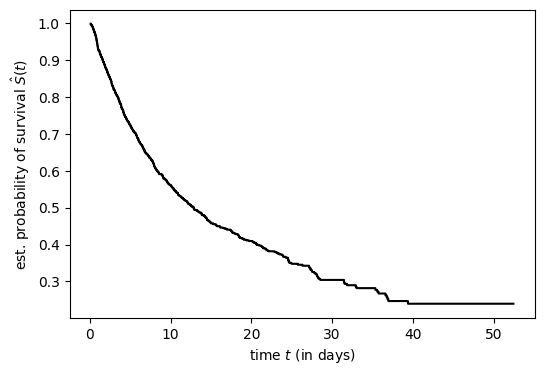

In [108]:
#Overall Survival
import matplotlib.pyplot as plt
data_complete['vital_status'] = data_complete['vital_status'].replace({'dead': 1, 'alive': 0}).astype('float64')

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

timedeath = data_complete['OS']
timedeath[data_complete['vital_status'] < 1.]

statusdeath = [x > 0. for x in data_complete['vital_status']]
time, survival_prob = kaplan_meier_estimator(statusdeath, timedeath)

plt.figure(figsize=(6, 4))
plt.step(time, survival_prob, where="post", color="black")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (in days)")
plt.show()

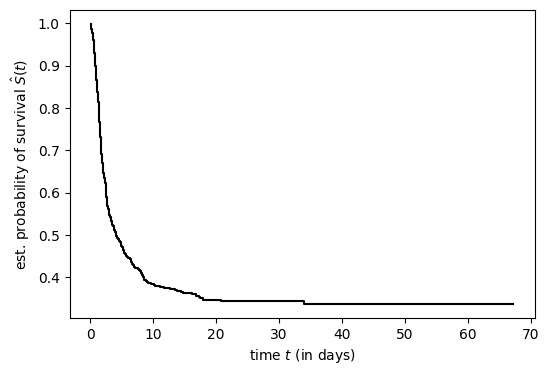

In [430]:

from sksurv.nonparametric import kaplan_meier_estimator

import matplotlib.pyplot as plt
%matplotlib inline

#Progression free survival- rename these variables!!!


plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

timedeath = data_complete['PFS']
timedeath[data_complete['vital_status'] < 1.]

statusdeath = [x > 0. for x in data_complete['vital_status']]
time, survival_prob = kaplan_meier_estimator(statusdeath, timedeath)

plt.figure(figsize=(6, 4))
plt.step(time, survival_prob, where="post", color="black")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (in days)")
plt.show()





In [109]:
# (de Kamps, 2023)
import numpy as np

# Random seed for the future
np.random.seed(42)

dfy = np.array(list(zip(statusdeath, timedeath)), dtype=[('Status', '?'), ('Survival_in_months', '<f8')])
print(dfy)

[(False,  9.59) (False, 50.14) (False,  9.99) ( True, 18.83)
 ( True,  2.33) ( True,  3.12) ( True,  7.13) (False,  3.22)
 (False, 48.82) ( True,  6.77) ( True,  5.52) (False, 16.1 )
 (False,  9.33) ( True,  7.89) ( True,  6.01) (False, 10.18)
 ( True,  4.5 ) (False, 12.29) (False, 13.54) (False, 38.64)
 (False, 17.38) ( True,  2.17) ( True, 18.6 ) ( True,  2.69)
 ( True,  4.63) ( True,  2.89) ( True,  0.13) ( True, 16.13)
 ( True,  0.95) (False, 30.13) ( True,  0.85) ( True,  0.39)
 (False, 24.77) ( True,  8.25) (False, 19.38) ( True,  4.21)
 (False,  5.26) ( True, 12.12) ( True,  6.6 ) ( True,  4.63)
 (False, 25.  ) (False,  9.69) ( True,  7.79) (False, 26.84)
 (False, 46.92) ( True, 13.21) ( True, 14.16) (False, 39.56)
 ( True, 20.93) (False, 52.44) (False, 20.44) ( True,  0.33)
 ( True, 12.12) ( True, 35.75) (False, 51.75) ( True,  7.62)
 ( True,  3.35) (False, 52.04) ( True, 27.47) ( True, 31.47)
 (False, 32.85) (False, 12.52) (False, 11.07) ( True,  3.25)
 ( True, 27.96) (False, 

In [110]:

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
encoder = LabelEncoder()

# List of variables to encode
variables_to_encode = ['age', 'best_response', 'stage', 'ECOG', 'msi_type', 'tx_line']

# Iterate over each variable and encode it separately
for var in variables_to_encode:
    encoded_var = encoder.fit_transform(data_complete[var])
    
    # Add the encoded variable back to the DataFrame
    data_complete[f'{var}_encoded'] = encoded_var

    # Print the shape of the encoded variable to ensure it's 1D
    print(data_complete)


         id  tx_year      age    nlr       msi_type  tmb_mutations_mb  \
2      8215     2018  61 - 70   1.38         Stable              19.3   
3      8216     2015  51 - 60   2.69         Stable               1.0   
4      8217     2018  51 - 60   2.54         Stable              10.5   
6      8219     2017  51 - 60   5.21         Stable               0.0   
8      8221     2016  61 - 70   2.18  Indeterminate               2.0   
...     ...      ...      ...    ...            ...               ...   
1624  10025     2018  51 - 60   9.25         Stable               0.0   
1626  10027     2018  61 - 70   6.50         Stable              12.3   
1627  10028     2018  71 - 95   4.82         Stable               9.7   
1629  10030     2018  51 - 60   4.92         Stable               3.5   
1630  10032     2018  41 - 50  34.67         Stable               9.7   

     best_response    PFS  vital_status     OS  ... cancer_type=LGI  \
2               PR   3.45           0.0   9.59  ... 

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3194138763.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_complete[f'{var}_encoded'] = encoded_var
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3194138763.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_complete[f'{var}_encoded'] = encoded_var
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3194138763.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [25]:
data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1192 entries, 2 to 2036
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1192 non-null   int64  
 1   tx_year                1192 non-null   int64  
 2   age                    1192 non-null   object 
 3   nlr                    1192 non-null   float64
 4   msi_type               1192 non-null   object 
 5   tmb_mutations_mb       1192 non-null   float64
 6   best_response          1192 non-null   object 
 7   PFS                    1192 non-null   float64
 8   vital_status           1192 non-null   float64
 9   OS                     1192 non-null   float64
 10  stage                  1192 non-null   object 
 11  tx_line                1192 non-null   object 
 12  ECOG                   1192 non-null   float64
 13  response=Yes           1192 non-null   float64
 14  clin_benefit=Yes       1192 non-null   float64
 15  canc

In [ ]:
#Create Ydata_Profiling Summary (takes a while to generate)
from ydata_profiling import ProfileReport
profile=ProfileReport(data_complete, title="Merged Summary")
profile.to_notebook_iframe()

In [26]:
column_names = data_complete.columns
print(column_names)

#include tx_year, nlr, tmb_mutations_mb

Index(['id', 'tx_year', 'age', 'nlr', 'msi_type', 'tmb_mutations_mb',
       'best_response', 'PFS', 'vital_status', 'OS', 'stage', 'tx_line',
       'ECOG', 'response=Yes', 'clin_benefit=Yes', 'cancer_type=GU',
       'cancer_type=LGI', 'cancer_type=Lung', 'cancer_type=Melanoma',
       'cancer_type=UGI', 'sex=Male', 'cohort=Validation', 'drug_class=ctla-4',
       'drug_class=pd-1/pd-l1', 'progression=Yes', 'age_encoded',
       'best_response_encoded', 'stage_encoded', 'ECOG_encoded',
       'msi_type_encoded', 'tx_line_encoded'],
      dtype='object')


In [111]:
# Filter columns containing 'best_response', 'age', 'OS', and 'vital_status'

#Having issues with collinearity

#There may be some wiggle room to play around with more cancer disease sites. 

#columns_to_select = data_complete.filter(like='best_response_encoded').columns.tolist()
#columns_to_select += data_complete.filter(like='stage_encoded').columns.tolist()
columns_to_select = data_complete.filter(like='sex').columns.tolist()
#columns_to_select += data_complete.filter(like='ECOG_encoded').columns.tolist()
#columns_to_select += data_complete.filter(like='msi_type_encoded').columns.tolist()
columns_to_select += data_complete.filter(like='drug_class').columns.tolist()
columns_to_select += data_complete.filter(like='progression').columns.tolist()
columns_to_select += data_complete.filter(like='cancer_type').columns.tolist()
columns_to_select += ['OS', 'vital_status', 'nlr','tmb_mutations_mb', 'age_encoded', 
                      'best_response_encoded', 'stage_encoded', 'ECOG_encoded',
                      'msi_type_encoded'
                      ]

#Need to figure out somehting to do with cancer type. and dage. What should I do with cohort?

# Select the desired columns
selected_columns = data_complete[columns_to_select]

# View the selected columns
print(selected_columns)



      sex=Male  drug_class=ctla-4  drug_class=pd-1/pd-l1  progression=Yes  \
2          0.0                0.0                    1.0              1.0   
3          0.0                0.0                    0.0              1.0   
4          0.0                0.0                    1.0              1.0   
6          1.0                0.0                    1.0              1.0   
8          0.0                0.0                    1.0              1.0   
...        ...                ...                    ...              ...   
1624       1.0                0.0                    1.0              1.0   
1626       1.0                0.0                    1.0              0.0   
1627       1.0                0.0                    1.0              1.0   
1629       1.0                0.0                    1.0              1.0   
1630       1.0                0.0                    1.0              1.0   

      cancer_type=GU  cancer_type=LGI  cancer_type=Lung  cancer_type=Melano

In [ ]:
#Pre-processing steps:
#Need to recategorize age and cancer subtype

In [112]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

#There are issues with multi-collinearity with my variables with the COX model

dfx = selected_columns.drop(['vital_status', 'OS'], axis=1, inplace=False)

estimator = CoxPHSurvivalAnalysis()
estimator.fit(dfx, dfy)
estimator.score(dfx, dfy)

0.7833947034471281

In [113]:
print("Shape of dfx:", dfx.shape)
print("Shape of dfy:", dfy.shape)


Shape of dfx: (990, 16)
Shape of dfy: (990,)


In [114]:
print(estimator.coef_)

[ 1.00721670e-01 -1.05148092e-01 -1.70175335e-01  1.87870570e+01
 -4.09240314e-01 -1.79795950e-01 -3.50239810e-01 -9.47282985e-01
 -1.32072864e-02  3.63724619e-02 -4.12327563e-04  2.50183782e-02
 -4.76441237e-01  4.07731721e-01  5.31484411e-01  9.65928583e-04]


In [115]:


from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator, dfx, dfy, cv=3)
print(f"Mean score CoxPH: {scores.mean():.3f} (std: {scores.std():.3f})")

Mean score CoxPH: 0.769 (std: 0.013)


In [116]:
import torch 

# Adapted from Pölsterl (2023); de Kamps (2023)

class CoxPHOptimizer:
    """Negative partial log-likelihood of Cox proportional hazards model."""

    def __init__(self, X, event, time, alpha, ties):
        """Initialize the model.

        Args:
            X (pandas.DataFrame): The dataset.
            event (array): List of events.
            time (array): List of times.
            alpha (array): List of L2 penalties for each coefficient.
            ties (string): Which method to use for ties. One of 'breslow' or 'efron'.

        Raises:
            ValueError: If ties is not one of 'breslow' or 'efron'.
        """
        # Sort descending
        o = np.argsort(-time, kind="mergesort")
        self.x = torch.tensor(X[o, :], dtype=torch.float)
        self.event = event[o]
        self.time = time[o]
        self.alpha = alpha
        # Method to handle ties
        if ties not in ("breslow", "efron"):
            raise ValueError("ties must be one of 'breslow', 'efron'")
        ties = "breslow"
        self._is_breslow = ties == "breslow"

    def nlog_likelihood(self, w=None, model=None):
        """Compute negative partial log-likelihood.

        Args:
            w (array, shape = (n_features,), optional): Estimate of coefficients. Defaults to None.
            model (torch.nn.Module, optional): The NN model. Defaults to None.

        Returns:
            float: Average negative partial log-likelihood (NPLL per event).
        """
        time = self.time
        n_samples = self.x.shape[0]
        breslow = self._is_breslow
        xw = []
                
        if model is not None:
            for i in range(n_samples):
                # Computes risk score for each sample using the NN model
                # and appends it to the list xw, containing the risk scores for all samples.
                xw.append(model.forward(self.x[i]))
                # self.update(model)
        else:
            # This is the critical line of code for our project. 
            # It is the matrix-vector product of the matrix of features x
            # and the vector of weights w.
            # This is what we will be replacing with our NNs.
            # As seen above, when the model is not None, we use the NN model.
            xw = self.x@w

        loss = 0
        risk_set = 0
        k = 0
        
        while k < n_samples:
            ti = time[k]
            numerator = 0
            n_events = 0
            risk_set2 = 0
            while k < n_samples and ti == time[k]:
                if self.event[k]:
                    numerator = numerator + xw[k]
                    risk_set2 = risk_set2 + torch.exp(xw[k])
                    n_events = n_events + 1
                else:
                    risk_set = risk_set + torch.exp(xw[k])
                k = k + 1

            if n_events > 0:
                if breslow:
                    risk_set = risk_set + risk_set2
                    loss = loss - (numerator - n_events * torch.log(risk_set)) / n_samples
                else:
                    numerator = numerator/n_events
                    for _ in range(n_events):
                        risk_set = risk_set + risk_set2 / n_events
                        loss = loss - (numerator - torch.log(risk_set)) / n_samples

        return loss
    
    # We adapted this entire function to use torch tensors instead of numpy arrays.
    def update(self, model, offset=0):
        """Compute and updates gradient and Hessian matrix.
        
        Args:
            model (torch.nn.Module): The NN model.
            offset (float, optional): The offset. Defaults to 0.
        """
        time = self.time
        x = self.x
        breslow = self._is_breslow
        n_samples, n_features = x.shape
        
        # Compute risk score for each sample using the NN model
        # Everything else in this function is the same as the original code
        exp_xw = []
        for i in range(n_samples):
            exp_xw.append(torch.exp(offset + model.forward(torch.tensor(x[i], dtype=torch.float32))).item())

        gradient = torch.zeros((1, n_features), dtype=torch.float64)
        hessian = torch.zeros((n_features, n_features), dtype=torch.float64)

        inv_n_samples = 1. / n_samples
        risk_set = 0
        risk_set_x = torch.zeros((1, n_features), dtype=torch.float64)
        risk_set_xx = torch.zeros((n_features, n_features), dtype=torch.float64)
        k = 0
        
        # Iterate time in descending order
        while k < n_samples:
            ti = time[k]
            n_events = 0
            numerator = 0
            risk_set2 = 0
            risk_set_x2 = torch.zeros_like(risk_set_x)
            risk_set_xx2 = torch.zeros_like(risk_set_xx)
            while k < n_samples and ti == time[k]:
                # Preserve 2D shape of row vector
                xk = x[k:k + 1]

                # Outer product
                xx = torch.matmul(xk.T, xk)

                if self.event[k]:
                    numerator += xk
                    risk_set2 += exp_xw[k]
                    risk_set_x2 += exp_xw[k] * xk
                    risk_set_xx2 += exp_xw[k] * xx
                    n_events += 1
                else:
                    risk_set += exp_xw[k]
                    risk_set_x += exp_xw[k] * xk
                    risk_set_xx += exp_xw[k] * xx
                k += 1

            if n_events > 0:
                if breslow:
                    risk_set += risk_set2
                    risk_set_x += risk_set_x2
                    risk_set_xx += risk_set_xx2

                    z = risk_set_x / risk_set
                    gradient -= (numerator - n_events * z) * inv_n_samples

                    a = risk_set_xx / risk_set
                    # outer product
                    b = torch.matmul(z.T, z)

                    hessian += n_events * (a - b) * inv_n_samples
                else:
                    numerator /= n_events
                    for _ in range(n_events):
                        risk_set += risk_set2 / n_events
                        risk_set_x += risk_set_x2 / n_events
                        risk_set_xx += risk_set_xx2 / n_events

                        z = risk_set_x / risk_set
                        gradient -= (numerator - z) * inv_n_samples

                        a = risk_set_xx / risk_set
                        # outer product
                        b = torch.matmul(z.T, z)

                        hessian += (a - b) * inv_n_samples

        self.gradient = gradient.ravel()
        self.hessian = hessian
    
    def zero(self):
        """Reset gradient and Hessian matrix."""
        self.gradient = 0
        self.hessian = 0

In [33]:
data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1192 entries, 2 to 2036
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1192 non-null   int64  
 1   tx_year                1192 non-null   int64  
 2   age                    1192 non-null   object 
 3   nlr                    1192 non-null   float64
 4   msi_type               1192 non-null   object 
 5   tmb_mutations_mb       1192 non-null   float64
 6   best_response          1192 non-null   object 
 7   PFS                    1192 non-null   float64
 8   vital_status           1192 non-null   float64
 9   OS                     1192 non-null   float64
 10  stage                  1192 non-null   object 
 11  tx_line                1192 non-null   object 
 12  ECOG                   1192 non-null   float64
 13  response=Yes           1192 non-null   float64
 14  clin_benefit=Yes       1192 non-null   float64
 15  canc

In [34]:

#Make sure it is the same data as above

data_complete_2 = data_complete[columns_to_select]
data_complete_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1192 entries, 2 to 2036
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sex=Male               1192 non-null   float64
 1   drug_class=ctla-4      1192 non-null   float64
 2   drug_class=pd-1/pd-l1  1192 non-null   float64
 3   progression=Yes        1192 non-null   float64
 4   cancer_type=GU         1192 non-null   float64
 5   cancer_type=LGI        1192 non-null   float64
 6   cancer_type=Lung       1192 non-null   float64
 7   cancer_type=Melanoma   1192 non-null   float64
 8   cancer_type=UGI        1192 non-null   float64
 9   OS                     1192 non-null   float64
 10  vital_status           1192 non-null   float64
 11  nlr                    1192 non-null   float64
 12  tmb_mutations_mb       1192 non-null   float64
 13  age_encoded            1192 non-null   int64  
 14  best_response_encoded  1192 non-null   int64  
 15  stag

In [35]:
%pip install lifelines

Note: you may need to restart the kernel to use updated packages.


In [36]:
data_complete_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1192 entries, 2 to 2036
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sex=Male               1192 non-null   float64
 1   drug_class=ctla-4      1192 non-null   float64
 2   drug_class=pd-1/pd-l1  1192 non-null   float64
 3   progression=Yes        1192 non-null   float64
 4   cancer_type=GU         1192 non-null   float64
 5   cancer_type=LGI        1192 non-null   float64
 6   cancer_type=Lung       1192 non-null   float64
 7   cancer_type=Melanoma   1192 non-null   float64
 8   cancer_type=UGI        1192 non-null   float64
 9   OS                     1192 non-null   float64
 10  vital_status           1192 non-null   float64
 11  nlr                    1192 non-null   float64
 12  tmb_mutations_mb       1192 non-null   float64
 13  age_encoded            1192 non-null   int64  
 14  best_response_encoded  1192 non-null   int64  
 15  stag

In [37]:
from sklearn.preprocessing import StandardScaler

#SCALING THE TWO CONTINUOUS VARIABLES HELPED A LOT

cancer_scaled = data_complete_2.copy()

# Normalise the data from 0 to 1
scaler = StandardScaler()

# Get the columns that need to be scaled
#cancer_columns_to_scale = [col for col in cancer_scaled.columns if col not in ['vital_status', 'OS']]
cancer_columns_to_scale = [col for col in cancer_scaled.columns if col in ['nlr', 'tmb_mutations_mb']]

# Fit the scaler to the data and transform the selected columns
cancer_scaled[cancer_columns_to_scale] = scaler.fit_transform(cancer_scaled[cancer_columns_to_scale])

display(cancer_scaled)

,sex=Male,drug_class=ctla-4,drug_class=pd-1/pd-l1,progression=Yes,cancer_type=GU,cancer_type=LGI,cancer_type=Lung,cancer_type=Melanoma,cancer_type=UGI,OS,vital_status,nlr,tmb_mutations_mb,age_encoded,best_response_encoded,stage_encoded,ECOG_encoded,msi_type_encoded
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,9.59,0.0,-0.703953,0.440382,4,2,3,0,1
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,50.14,0.0,-0.509872,-0.515870,3,1,3,0,1
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,9.99,0.0,-0.532095,-0.019455,3,2,3,0,1
6,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,18.83,1.0,-0.136524,-0.568124,3,2,3,0,1
8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.33,1.0,-0.585430,-0.463616,4,1,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,9.86,1.0,-0.375052,-0.432263,3,3,3,1,1
2033,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,13.31,0.0,-0.554318,-0.338205,2,1,3,0,1
2034,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,10.48,1.0,-0.692101,-0.432263,2,3,3,0,1
2035,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,10.51,0.0,-0.552836,-0.432263,1,1,2,0,1


In [38]:
# (de Kamps, 2023)

%pip install lifelines

# (de Kamps, 2023)
#from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

cph_IO = CoxPHFitter().fit(cancer_scaled, 'vital_status', 'OS')
cph_IO.print_summary(columns=["coef", "se(coef)", "p"])

# Store the coefficients
cph_IO_coef = cph_IO.summary['coef']

Note: you may need to restart the kernel to use updated packages.


<lifelines.CoxPHFitter: fitted with 1192 total observations, 0 right-censored observations>
             duration col = 'vital_status'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 1192
number of events observed = 1192
   partial log-likelihood = -7059.89
         time fit was run = 2024-03-06 23:22:07 UTC

---
                        coef   se(coef)      p
covariate                                     
sex=Male                0.01       0.06   0.87
drug_class=ctla-4      -0.17       0.47   0.72
drug_class=pd-1/pd-l1   0.04       0.08   0.64
progression=Yes        -1.86       0.10 <0.005
cancer_type=GU         -0.08       0.25   0.76
cancer_type=LGI        -0.10       0.28   0.73
cancer_type=Lung       -0.07       0.25   0.77
cancer_type=Melanoma    0.05       0.26   0.84
cancer_type=UGI        -0.09       0.25   0.71
nlr                    -0.07       0.03   0.04
tmb_mutations_mb       -0.00       0.03   0.97
age_encoded            -0.03       0.03   0.29
best_response_encoded   0.11       0.03 <0.005
stage_encoded          -0.05       0.11   0.61
ECOG_encoded           -0.11       0.05   0.02
msi_type_encoded        0.02       0.12   0.86
---
Concordance = 0.84
Partial AIC = 14151.78
log-likelihood ratio test = 391.94 on 16 df
-log2(p) of ll-ratio test = 241.67

In [117]:


#It seems like no penelty is better, some exampels of lasso (l1) and ridge (l2) penalty
cph_IOa = CoxPHFitter(penalizer=0.01, l1_ratio=1).fit(cancer_scaled, 'vital_status', 'OS') # Set the penalizer value for L1 penalty
cph_IOa.print_summary(columns=["coef", "se(coef)", "p"])

# Store the coefficients
cph_IO_coef = cph_IOa.summary['coef']



cph_IOb = CoxPHFitter(penalizer=0.01, l1_ratio=0).fit(cancer_scaled, 'vital_status', 'OS') # Set the penalizer value for L2 penalty and l1_ratio=0 for Ridge penalty
cph_IOb.print_summary(columns=["coef", "se(coef)", "p"])

# Store the coefficients
cph_IO_coef = cph_IOb.summary['coef']


<lifelines.CoxPHFitter: fitted with 1192 total observations, 0 right-censored observations>
             duration col = 'vital_status'
                event col = 'OS'
                penalizer = 0.01
                 l1 ratio = 1
      baseline estimation = breslow
   number of observations = 1192
number of events observed = 1192
   partial log-likelihood = -7072.22
         time fit was run = 2024-03-08 17:56:54 UTC

---
                        coef   se(coef)      p
covariate                                     
sex=Male                0.00       0.00   1.00
drug_class=ctla-4      -0.01       0.42   0.98
drug_class=pd-1/pd-l1   0.00       0.08   0.96
progression=Yes        -1.83       0.10 <0.005
cancer_type=GU          0.00       0.00   1.00
cancer_type=LGI        -0.00       0.00   1.00
cancer_type=Lung       -0.00       0.00   1.00
cancer_type=Melanoma    0.09       0.10   0.37
cancer_type=UGI        -0.00       0.00   1.00
nlr                    -0.06       0.03   0.06
tmb_mutations_mb        0.00       0.00   1.00
age_encoded            -0.02       0.03   0.50
best_response_encoded   0.10       0.03 <0.005
stage_encoded          -0.03       0.11   0.76
ECOG_encoded           -0.11       0.05   0.03
msi_type_encoded        0.00       0.00   1.00
---
Concordance = 0.84
Partial AIC = 14176.45
log-likelihood ratio test = 367.27 on 16 df
-log2(p) of ll-ratio test = 224.53

<lifelines.CoxPHFitter: fitted with 1192 total observations, 0 right-censored observations>
             duration col = 'vital_status'
                event col = 'OS'
                penalizer = 0.01
                 l1 ratio = 0
      baseline estimation = breslow
   number of observations = 1192
number of events observed = 1192
   partial log-likelihood = -7063.05
         time fit was run = 2024-03-08 17:56:54 UTC

---
                        coef   se(coef)      p
covariate                                     
sex=Male                0.01       0.06   0.87
drug_class=ctla-4      -0.16       0.46   0.73
drug_class=pd-1/pd-l1   0.04       0.08   0.65
progression=Yes        -1.83       0.10 <0.005
cancer_type=GU         -0.05       0.21   0.80
cancer_type=LGI        -0.08       0.24   0.74
cancer_type=Lung       -0.05       0.20   0.79
cancer_type=Melanoma    0.07       0.22   0.74
cancer_type=UGI        -0.07       0.21   0.73
nlr                    -0.07       0.03   0.03
tmb_mutations_mb        0.00       0.03   1.00
age_encoded            -0.03       0.03   0.29
best_response_encoded   0.11       0.03 <0.005
stage_encoded          -0.06       0.11   0.59
ECOG_encoded           -0.11       0.05   0.02
msi_type_encoded        0.02       0.12   0.86
---
Concordance = 0.84
Partial AIC = 14158.10
log-likelihood ratio test = 385.62 on 16 df
-log2(p) of ll-ratio test = 237.27

In [130]:
#Check to make sure that I used the correct dataframe. 

# Compute direct correlations of selected features with the target variable
correlations_original = data_complete.corrwith(data_complete['vital_status'])
# Sort them according the strength of correlations.
correlations_index = correlations_original.abs().sort_values(kind="quicksort", ascending=False).index
# Use index to sort correlations
correlations = correlations_original[correlations_index]
# Display correlation value from original dataframe
correlations_df = pd.DataFrame(correlations, index=correlations.index, columns=['Correlation'])
# Print correlations
display(correlations_df)

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3590280642.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations_original = data_complete.corrwith(data_complete['vital_status'])


,Correlation
vital_status,1.000000
OS,-0.579911
PFS,-0.559640
clin_benefit=Yes,-0.555643
progression=Yes,0.545878
response=Yes,-0.500643
ECOG,0.257975
ECOG_encoded,0.257975
tx_line_encoded,0.230455
nlr,0.217351


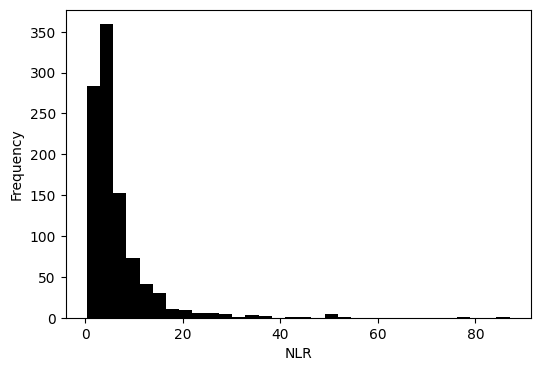

In [133]:
# Calculates number of bins for the histograms by taking the square root of the number of data points (comes out as 50)
n_bins = int(np.ceil(np.sqrt(data_complete.shape[0])))

# Plot histogram for ClinicAge
# Set figure size
plt.figure(figsize=(6, 4))
plt.hist(data_complete['nlr'], bins=n_bins, color="black")
plt.xlabel('NLR')
plt.ylabel('Frequency')
plt.show()

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/368710973.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation=data_complete.corr().abs()


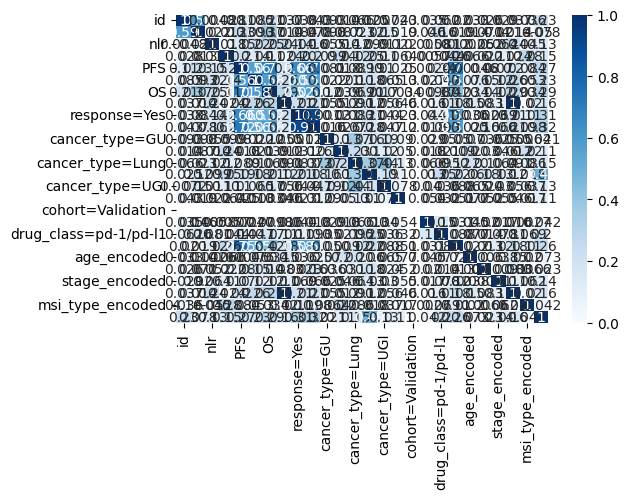

In [132]:

# Create heatmap of all correlations. This looks terrible, need to be more selective of my variables

import seaborn as sns
correlation=data_complete.corr().abs()
heatmap = sns.heatmap(correlation, vmin=0, vmax=1, annot=True, cmap='Blues')
plt.show()

In [41]:
# Adapted from de Kamps (2023); Ching et al. (2018)
# We allow pasing in a model when computing the log-likelihood

torch.autograd.set_detect_anomaly = True

class CoxNNet(torch.nn.Module):
    """CoxNNet model for survival analysis."""

    def __init__(self, df, event, time, coefficients=None):
        """Initialize the CoxNNet model.

        Args:
            df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
            event (str): Name of the event column. 
            time (str): Name of the time column.
            coefficients (torch.Tensor, optional): Initial coefficients. Defaults to None.
        """

        super().__init__()

        self.covariates = [x for x in df.columns if x != event and x != time]
        self.df = df
        self.dfx = df[self.covariates].to_numpy(dtype=float)
        self.events = df[event].to_numpy(dtype=float)
        self.times = df[time].to_numpy(dtype=float)
        
        n_covariates = len(self.covariates)
        
        # If no coefficients are passed in, we initialize them randomly
        if coefficients == None:
            # Set random seed for reproducibility
            torch.manual_seed(42)
            self.coefficients = torch.randn(n_covariates, requires_grad=True, dtype=torch.float)
        # Otherwise we use the coefficients passed in
        else:
            self.coefficients = coefficients.clone().detach().requires_grad_(True)
        # print(self.coefficients)
        
        # This line is used in coxpy to initialize the alphas
        alphas = torch.zeros(self.dfx.shape[1])
        
        self.opt = CoxPHOptimizer(self.dfx, self.events, self.times, alphas, 'breslow')

    def forward(self, model=None):
        """Calculate the log-likelihood over the entire dataset.
        This is the function that is called when we call net.forward().
        Important: this is where we can pass in a NN model.

        Args:
            model (torch.nn.Module, optional): NN model to use. Defaults to None.

        Returns:
            float: Log-likelihood over the entire dataset.
        """
        # sksurv calculates the llh /event and puts a minus sign in front, we undo that
        total = -self.df.shape[0]*self.opt.nlog_likelihood(self.coefficients, model)
        return total

# Simply testing to make sure the code works
  

# Generate a tensor. THis needs to equal the number of covariates excluding vital_status and OS
num_features = 16

# Generate a tensor with random values for the coefficients, matching the number of features
c = torch.randn(num_features)
#c = torch.randn(26)

#c = torch.tensor([-0.38, -0.06, 0.31, -0.15, -0.43, -0.08, 0.09])
net = CoxNNet(cancer_scaled, 'vital_status', 'OS', coefficients=c)
loss = net.forward()
print("Loss:", loss.item())


Loss: -6022.45068359375


In [127]:
# Adapted from de Kamps (2023)
def gradient_descent(df, event, time, lr, n_epoch, coefficients=None):
    """Performs gradient descent on the Cox model.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        lr (float): Learning rate.
        n_epoch (int): Number of epochs (iterations to run).
        coefficients (torch.Tensor, optional): Initial coefficients. Defaults to None.

    Returns:
        torch.nn.Module: The trained CoxNNet model (with updated coefficients).
    """
    
    net = CoxNNet(df, event, time, coefficients)
    loss = net.forward()
    print("Initial Loss:", loss.item())
    
    # Iterate n_epoch times
    for _ in range(n_epoch):
        # Updates the coefficients using autograd
        loss = net.forward()
        loss.backward()
        with torch.no_grad():
            # Use the specified learning rate
            net.coefficients += net.coefficients.grad * lr
            net.coefficients.grad.zero_()
    loss = net.forward()
    
    # Print the final loss and the updated coefficients
    print("Final Loss:", loss.item())
    print("Coefficients:", net.coefficients.detach().numpy())
    return net

#Two values at the end refer to the learning rate, and the number of epochs
#We initially started with 4000 epochs
cancer_net = gradient_descent(cancer_scaled, 'vital_status', 'OS', 0.0001, 4000)

Initial Loss: -8287.232421875
Final Loss: -4120.82861328125
Coefficients: [ 4.7303725e-02  1.2999640e-01 -1.1423099e-01  4.6422367e+00
 -5.9228075e-01 -1.7265776e-01 -3.9677235e-01 -9.8052716e-01
 -3.9675511e-02  2.5192583e-01  4.6207532e-03  3.2344863e-02
 -4.7029576e-01  3.7231320e-01  5.2899313e-01 -4.8477776e-02]


In [174]:



def gradient_descent(df, event, time, lr, n_epoch, coefficients=None, variable_names=None):
    """Performs gradient descent on the Cox model.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        lr (float): Learning rate.
        n_epoch (int): Number of epochs (iterations to run).
        coefficients (torch.Tensor, optional): Initial coefficients. Defaults to None.
        variable_names (list, optional): List of variable names. Defaults to None.

    Returns:
        torch.nn.Module: The trained CoxNNet model (with updated coefficients).
    """
    
    net = CoxNNet(df, event, time, coefficients)
    loss = net.forward()
    print("Initial Loss:", loss.item())
    
    # Iterate n_epoch times
    for _ in range(n_epoch):
        # Updates the coefficients using autograd
        loss = net.forward()
        loss.backward()
        with torch.no_grad():
            # Use the specified learning rate
            net.coefficients += net.coefficients.grad * lr
            net.coefficients.grad.zero_()
    loss = net.forward()
    
    # Print the final loss and the updated coefficients
    print("Final Loss:", loss.item())
    
    if variable_names is not None:
        print("Variable Names:", variable_names)
    print("Coefficients:", net.coefficients.detach().numpy())

    return net

# Two values at the end refer to the learning rate, and the number of epochs
# We initially started with 4000 epochs
# Provide variable names as a list
variable_names = [
    'sex=Male',
    'drug_class=ctla-4',
    'drug_class=pd-1/pd-l1',
    'progression=Yes',
    'cancer_type=GU',
    'cancer_type=LGI',
    'cancer_type=Lung',
    'cancer_type=Melanoma',
    'cancer_type=UGI',
    'nlr',
    'tmb_mutations_mb',
    'age_encoded',
    'best_response_encoded',
    'stage_encoded',
    'ECOG_encoded',
    'msi_type_encoded'
]
cancer_net = gradient_descent(cancer_scaled, 'vital_status', 'OS', 0.0001, 4000, variable_names=variable_names)



Initial Loss: -8287.232421875
Final Loss: -4120.82861328125
Variable Names: ['sex=Male', 'drug_class=ctla-4', 'drug_class=pd-1/pd-l1', 'progression=Yes', 'cancer_type=GU', 'cancer_type=LGI', 'cancer_type=Lung', 'cancer_type=Melanoma', 'cancer_type=UGI', 'nlr', 'tmb_mutations_mb', 'age_encoded', 'best_response_encoded', 'stage_encoded', 'ECOG_encoded', 'msi_type_encoded']
Coefficients: [ 4.7303725e-02  1.2999640e-01 -1.1423099e-01  4.6422367e+00
 -5.9228075e-01 -1.7265776e-01 -3.9677235e-01 -9.8052716e-01
 -3.9675511e-02  2.5192583e-01  4.6207532e-03  3.2344863e-02
 -4.7029576e-01  3.7231320e-01  5.2899313e-01 -4.8477776e-02]


In [118]:
# Variable names and coefficients

#This output appears to be the closest to the initial survival analysis


variable_names = ['sex=Male', 'drug_class=ctla-4', 'drug_class=pd-1/pd-l1', 'progression=Yes', 'cancer_type=GU', 'cancer_type=LGI', 'cancer_type=Lung', 'cancer_type=Melanoma', 'cancer_type=UGI', 'nlr', 'tmb_mutations_mb', 'age_encoded', 'best_response_encoded', 'stage_encoded', 'ECOG_encoded', 'msi_type_encoded']
coefficients = [4.7303725e-02, 1.2999640e-01, -1.1423099e-01, 4.6422367e+00, -5.9228075e-01, -1.7265776e-01, -3.9677235e-01, -9.8052716e-01, -3.9675511e-02, 2.5192583e-01, 4.6207532e-03, 3.2344863e-02, -4.7029576e-01, 3.7231320e-01, 5.2899313e-01, -4.8477776e-02]

# Print variable names and coefficients
print("Variable Names and Coefficients:")
for name, coef in zip(variable_names, coefficients):
    print(f"{name}: {coef}")


Variable Names and Coefficients:
sex=Male: 0.047303725
drug_class=ctla-4: 0.1299964
drug_class=pd-1/pd-l1: -0.11423099
progression=Yes: 4.6422367
cancer_type=GU: -0.59228075
cancer_type=LGI: -0.17265776
cancer_type=Lung: -0.39677235
cancer_type=Melanoma: -0.98052716
cancer_type=UGI: -0.039675511
nlr: 0.25192583
tmb_mutations_mb: 0.0046207532
age_encoded: 0.032344863
best_response_encoded: -0.47029576
stage_encoded: 0.3723132
ECOG_encoded: 0.52899313
msi_type_encoded: -0.048477776


In [119]:
# Train the NN using gradient descent
def train_model(df, event, time, model, lr, n_epoch, output=False):
    """Trains a NN model using gradient descent.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        model (_type_): NN model.
        lr (float): Learning rate.
        n_epoch (int): Number of epochs (iterations to run).
        output (bool, optional): Whether to print the loss before and after training. Defaults to True.
        
    Returns:
        float: The final loss.
    """
    net = CoxNNet(df, event, time)
    losses = []
    
    # Print the initial loss before training
    if output:
        print("Initial Loss:", net.forward(model).item())
    
    # Train the model
    for _ in range(n_epoch):
        # Compute the loss using the CoxNNet class and the NN model
        loss = net.forward(model)
        loss.backward()        
        losses.append(loss)
        
        # Update the weights using gradient descent
        with torch.no_grad():
            for param in model.parameters():
                param += param.grad * lr
            model.zero_grad()
    
    # Print the final loss
    if output:
        print("Final Loss:", net.forward(model).item())
        
        # Produce a plot of the loss over the epochs
        losses = [x.detach().numpy() for x in losses]
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, n_epoch+1), losses, color='black')
        plt.xlabel('Epochs')
        plt.ylabel('Negative Partial Log-Likelihood Loss')
        plt.show()
    
    # Return the final PLE loss of the final trained model
    return losses[-1]

In [120]:
def concordance_statistic(risks, events, times, output=True):
    """Calculates the c-statistic for a given set of predicted risks and actual events and times.

    Args:
        risks (array): List of predicted risks.
        events (array): List of event indicators.
        times (array): List of survival times.

    Returns:
        float: c-statistic.
    """
    valid_pairs = 0
    concordant_pairs = 0
    discordant_pairs = 0
    tied_pairs = 0
    
    # Convert risks tensor to NumPy array
    if isinstance(risks, torch.Tensor):
        risks = risks.detach().cpu().numpy()
    
    # Sort risks, events, and times based on the times
    sorted_indices = np.argsort(times)
    risks = np.array(risks)[sorted_indices]
    events = np.array(events)[sorted_indices]
    times = np.array(times)[sorted_indices]

    n_samples = len(risks)
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if times[i] != times[j]:
                if events[i] and (times[i] < times[j]):
                    valid_pairs += 1
                    if risks[i] > risks[j]:
                        concordant_pairs += 1
                    elif risks[i] < risks[j]:
                        discordant_pairs += 1
                    else:
                        tied_pairs += 1

                elif events[j] and (times[j] < times[i]):
                    valid_pairs += 1
                    if risks[j] > risks[i]:
                        concordant_pairs += 1
                    elif risks[j] < risks[i]:
                        discordant_pairs += 1
                    else:
                        tied_pairs += 1
    
    # We can optionally produce a plot of the risk scores over time
    # This is useful for visualising the risk scores
    # Ideally, we would like to see the risk scores of the events (i.e. 1) higher than the non-events (i.e. 0)
    # This is because the risk scores are the log-hazard ratios
    if output:
        # Plots the risk scores over time
        plt.figure(figsize=(6, 4))
        colors = np.where(events, 'orange', 'blue')

        for color, label in zip(['orange', 'blue'], ['Event', 'Non-Event']):
            mask = (colors == color)
            plt.scatter(times[mask], np.array(risks)[mask], alpha=0.3, color=color, label=label)

        plt.xlabel('Time')
        plt.ylabel('Risk')
        plt.legend()
        plt.show()
    
    # Note we do not actually need to use discordant_pairs in the calculation
    # Since we already increment valid_pairs when we encounter a discordant pair
    return (concordant_pairs + 0.5 * tied_pairs) / valid_pairs

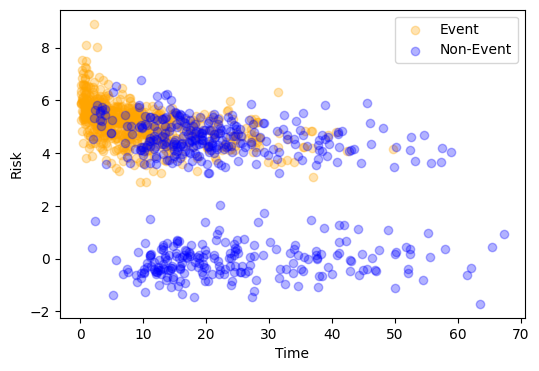

Base Cancer Score: 0.7950425467111374


In [121]:
def get_concordance_statistic(df, event, time, net, output=True):
    """Calculates the c-statistic for a given dataset for the CoxNNet model.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        net (torch.nn.Module): CoxNNet model.

    Returns:
        float: c-statistic.
    """
    # Calculate the predicted risk for each individual in the dataset
    risks = np.matmul(net.dfx, net.coefficients.detach().numpy())
    
    return concordance_statistic(risks, df[event].to_numpy(), df[time].to_numpy(), output)

print("Base Cancer Score:", get_concordance_statistic(cancer_scaled, 'vital_status', 'OS', cancer_net))

In [122]:
# Calculate the predicted risk for each individual in the dataset
def get_concordance_statistic_nn(df, event, time, model, output=True):
    """Calculates the c-statistic for a given dataset using a NN model to compute predicted risks.

    Args:
        df (pandas.DataFrame): Dataframe containing the covariates and the event and time columns.
        event (str): Name of the event column.
        time (str): Name of the time column.
        model (torch.nn.Module): NN model.
        output (bool, optional): Whether to print the loss before and after training. Defaults to True.

    Returns:
        float: c-statistic.
    """
    # Calculate the predicted risk for each individual in the dataset using the NN
    x = torch.tensor(df[[col for col in df.columns if col not in [event, time]]].values, dtype=torch.float)    
    with torch.no_grad():
        predicted_risk = np.array([model.forward(xi).item() for xi in x])
    
    # Compute the c-statistic
    return concordance_statistic(predicted_risk, df[event].to_numpy(), df[time].to_numpy(), output)

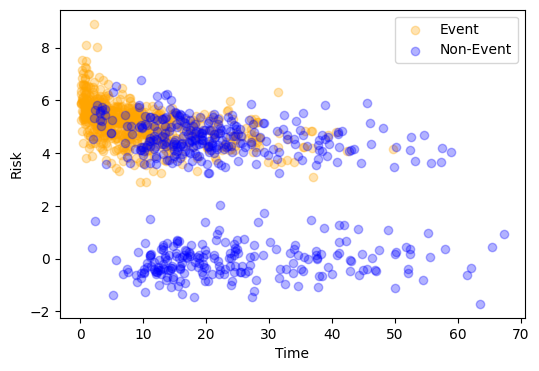

FWL Cancer Score: 0.7950425467111374


In [49]:
# This NN essentially computes the same as the CoxPH model
# i.e. xw = self.x@w = x1w1 + x2w2 + x3w3 + x4w4 + ... + xnw_n
# This is computed in the forward pass
# We call it linear because it is a linear model, i.e. it is a linear combination of the covariates
# and does not have any hidden layers, thus not capturing any non-linear relationships.
class FixedWeightLinear(torch.nn.Module):
    """Simple NN with no hidden layers that simply computes the dot product of the input and the weights.
    This is essentially the same as the CoxPH model.
    We do not train this model, we simply use it to compute the predicted risk for each individual in the dataset.
    """
    
    def __init__(self, weights):
        """Initializes the FWL model.

        Args:
            weights (torch.Tensor): Weights to use for the dot product.
        """
        super(FixedWeightLinear, self).__init__()
        # Initialize the weights as a torch.nn.Parameter
        self.weights = torch.nn.Parameter(weights.clone().detach().requires_grad_(True))

    def forward(self, x):
        """Simply multiply the weights by the input.

        Args:
            x (array): List of covariates for a single individual.

        Returns:
            float: Predicted risk.
        """
        return torch.matmul(x, self.weights)
    
# Initialize the FWL model with the learned coefficients
cancer_fwl = FixedWeightLinear(cancer_net.coefficients)

# Compute the c-statistic using the FWL model
print("FWL Cancer Score:", get_concordance_statistic_nn(cancer_scaled, 'vital_status', 'OS', cancer_fwl))

In [123]:
# This class lets us use random weights for each feature
class VariableWeightLinear(FixedWeightLinear):
    """Simple NN with no hidden layers that simply computes the dot product of the input and the weights.
    However, the weights are randomly initialized and then trained using gradient descent."""
    
    def __init__(self, n):
        """Initializes the VWL model.

        Args:
            n (int): Number of features in the dataset.
        """
        # Randomise weights
        torch.manual_seed(42)
        weights = torch.nn.Parameter(torch.randn(n, requires_grad=True, dtype=torch.float))
        super(VariableWeightLinear, self).__init__(weights)
        # Print these initial weights
        print("Initial VWL", self.weights)

    def forward(self, x):
        """Simply multiply the weights by the input.

        Args:
            x (array): List of covariates for a single individual.

        Returns:
            float: Predicted risk.
        """
        # Again, simply multiply the weights by the input
        return torch.matmul(x, self.weights)
    
# Initialize the VariableWeightLinear model
n_covariates = len([x for x in cancer_scaled.columns if x != 'vital_status' and x != 'OS'])
cancer_vwl = VariableWeightLinear(n_covariates)

# Compute the c-statistic using the trained VWL model
print("Initial VWL Cancer Score:", get_concordance_statistic_nn(cancer_scaled, 'vital_status', 'OS', cancer_vwl, False))

Initial VWL Parameter containing:
tensor([ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047,
        -0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594, -0.7688,  0.7624],
       requires_grad=True)
Initial VWL Cancer Score: 0.4849347416551667


In [124]:
# Train the model using the train_model function we created before
cancer_vwl_loss = train_model(cancer_scaled, 'vital_status', 'OS', cancer_vwl, 0.0001, 4000, False)

# Compute the c-statistic using the trained VWL model
cancer_vwl_c = get_concordance_statistic_nn(cancer_scaled, 'vital_status', 'OS', cancer_vwl, False)

# Print the trained weights and loss in format string
print("Trained VWL Rossi Weights: {0} \
      \nTrained VWL Rossi Loss: {1} \
      \nTrained VWL Rossi Score {2}"
      .format(cancer_vwl.weights, cancer_vwl_loss, cancer_vwl_c))

Trained VWL Rossi Weights: Parameter containing:
tensor([ 4.7304e-02,  1.3000e-01, -1.1423e-01,  4.6422e+00, -5.9228e-01,
        -1.7266e-01, -3.9677e-01, -9.8053e-01, -3.9676e-02,  2.5193e-01,
         4.6208e-03,  3.2345e-02, -4.7030e-01,  3.7231e-01,  5.2899e-01,
        -4.8478e-02], requires_grad=True)       
Trained VWL Rossi Loss: -4120.82958984375       
Trained VWL Rossi Score 0.7950425467111374


In [53]:
def plot_weights(weights):
    """Plots the distribution of the weights.

    Args:
        weights (torch.Tensor): Weights to plot.
    """
    
    plt.figure(figsize=(6, 4))
    plt.hist(weights, bins=int(np.sqrt(len(weights))), color='black')
    plt.xlabel('Weights')
    plt.ylabel('Frequency')
    plt.show()

class SNN(torch.nn.Module):
    """Simple NN with one hidden layer."""
    
    def __init__(self, input_size, hidden_size=None):
        """Initializes the SNN model.

        Args:
            input_size (int): Number of covariates.
            hidden_size (int): Number of neurons in the hidden layer.
        """
        
        # Randomise weights
        torch.manual_seed(42)
        
        super(SNN, self).__init__()
        # Store the input and hidden sizes
        self.input_size = input_size
        # If no hidden size is specified, use the sqrt(input_size + 1) rounded up
        if hidden_size is None:
            self.hidden_size = np.sqrt(input_size + 1).astype(int) + 1
        else:
            self.hidden_size = hidden_size
        
        # Create the layers
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, 1)
        
        # Create the model
        self.model = torch.nn.Sequential(self.fc1, self.relu, self.fc2)

    def forward(self, x):
        """Predicts the risk for a single individual.

        Args:
            x (array): List of covariates for a single individual.

        Returns:
            float: Predicted risk.
        """
        return self.model(x)
    
    def return_weights(self):
        """Plots the weights in a histogram."""
        
        plot_weights(torch.cat([self.fc1.weight.view(-1), self.fc1.bias, self.fc2.weight.view(-1), self.fc2.bias]).detach().numpy())

Initial Loss: -4514.1181640625
Final Loss: -4160.67822265625


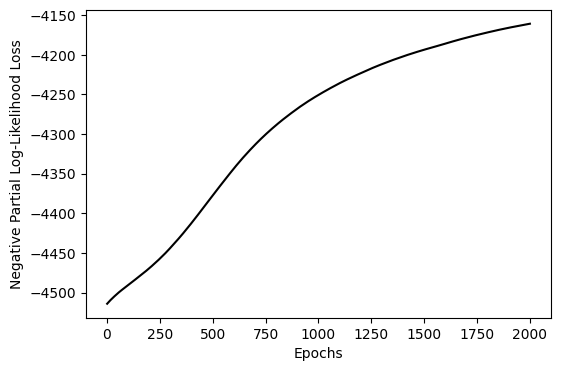

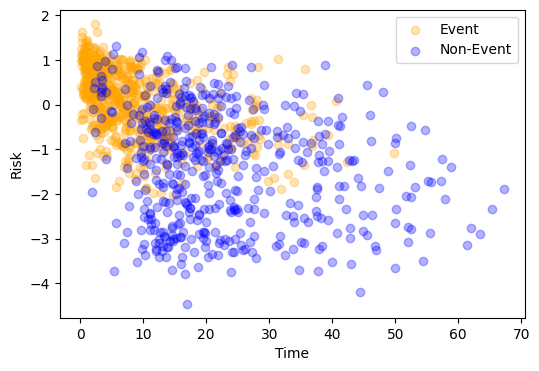

SNN[16, 5, 1] 
- Loss: [-4160.726]
- Score: 0.788259138236389


(array([-4160.726], dtype=float32), 0.788259138236389)

In [54]:
# This allows us to test different architectures of the `NN` model
def test_nn(df, event, time, model, lr, n_epoch, output=False):
    """Trains the model and prints the c-statistic.

    Args:
        df (pandas.DataFrame): Dataset to use.
        event (str): Name of the event column.
        time (str): Name of the time column.
        model (torch.nn.Module): NN model.
        lr (float): Learning rate.
        n_epoch (int): Number of epochs.
        output (bool, optional): Whether to print the output. Defaults to False.
    """
    
    loss = train_model(df, event, time, model, lr, n_epoch, output)
    score = get_concordance_statistic_nn(df, event, time, model, output)
    
    if output:
        # Print format string with loss and score
        param = ""
        if type(model).__name__ == "SNN":
            param = f"[{model.input_size}, {model.hidden_size}, 1]"
        elif type(model).__name__ == "GNN": # This will be useful later
            param = model.layer_sizes
        print(f"{type(model).__name__}{param} \n- Loss: {loss}\n- Score: {score}")
    return loss, score

# Test the simple model on the cancer data set
input_size = cancer_scaled.shape[1] - 2  # Number of input features (excluding censor and time variables)
hidden_size = (np.sqrt(input_size + 1)).astype(int) + 1  # Number of hidden units
cancer_snn = SNN(input_size, hidden_size)
test_nn(cancer_scaled, 'vital_status', 'OS', cancer_snn, 0.00001, 2000, True)

In [55]:


#This takes quite a while to run


# Create a loop to test different architectures (begin with 1 neuron in single hidden layer, increase in steps of 1 until 2 * input_size)
cancer_snn_losses = []
cancer_snn_scores = []

# This allows us to test different architectures of the NN model
# We do not want to add too many neurons because this can lead to overfitting
cancer_snn_hidden_sizes = [1 + i for i in range(input_size * 2)]

# This stores the best model and its score
cancer_snn_best = [None, 0, 0]

# Loop through the different architectures
for i in cancer_snn_hidden_sizes:
    model = SNN(input_size, i)
    loss, score = test_nn(cancer_scaled, 'vital_status', 'OS', model, 0.0001, 1000, False)
    loss = loss.detach().numpy()
    if score > cancer_snn_best[2]:
        cancer_snn_best = [model, loss, score]
    cancer_snn_losses.append(loss)
    cancer_snn_scores.append(score)

# Print the scores of the best architecture
print("Best SNN Rossi: \
    \n- Architecture: SNN[{0}, {1}, 1] \
    \n- Loss: {2} \
    \n- Score: {3}"
    .format(input_size, cancer_snn_best[0].hidden_size, cancer_snn_best[1], cancer_snn_best[2]))

Best SNN Rossi:     
- Architecture: SNN[16, 22, 1]     
- Loss: [-4009.2012]     
- Score: 0.821427899963526


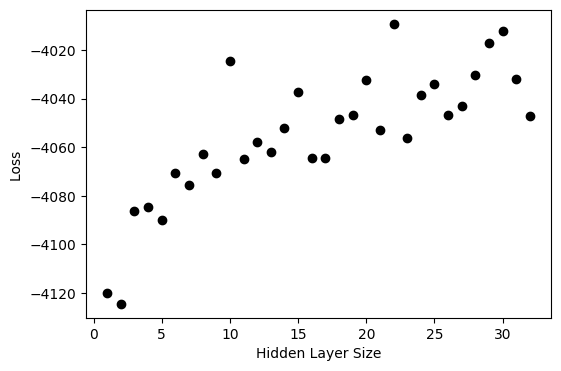

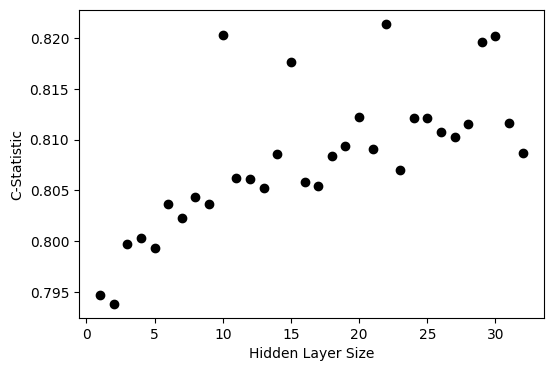

In [56]:
# Plot the losses
plt.figure(figsize=(6, 4))
plt.scatter(cancer_snn_hidden_sizes, cancer_snn_losses, label='Loss', color='black')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Loss ')
plt.show()

# Plot the c-Score scores
plt.figure(figsize=(6, 4))
plt.scatter(cancer_snn_hidden_sizes, cancer_snn_scores, label='C-Statistic', color='black')
plt.xlabel('Hidden Layer Size')
plt.ylabel('C-Statistic')
plt.show()

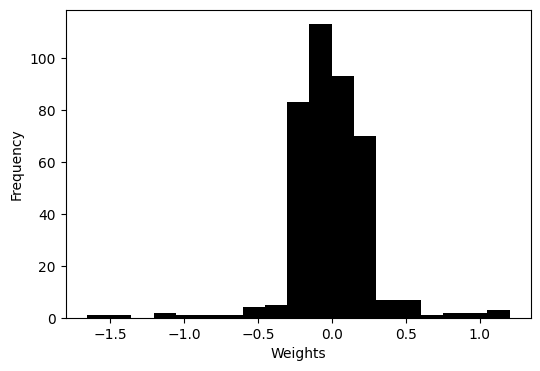

In [57]:
# Use a histogram with n_bins = size of data square root
cancer_snn_best[0].return_weights()

In [58]:
class GNN(torch.nn.Module):
    """General NN with any number of hidden layers with any number of neurons."""
    
    def __init__(self, layer_sizes):
        """Initializes the GNN model.

        Args:
            layer_sizes (array): List of the number of neurons in each layer.
        """
        
        # Randomise weights
        torch.manual_seed(42)
        super(GNN, self).__init__()
        # We want to store the sizes in a list for the future
        self.layer_sizes = layer_sizes
        # Create a list of layers
        self.layers = torch.nn.ModuleList()        
        # Create the layers based on the input sizes
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer
            self.layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            # Add a ReLU activation function after every linear layer except the last one
            if i < len(layer_sizes) - 2:  # Don't add ReLU activation after the last linear layer
                self.layers.append(torch.nn.ReLU())
        # Create the model
        self.model = torch.nn.Sequential(*self.layers)

    def forward(self, x):
        """Predicts the risk for a single individual.

        Args:
            x (array): List of covariates for a single individual.

        Returns:
            float: Predicted risk.
        """
        return self.model(x)

    def return_weights(self):
        """Plots the weights in a histogram."""
        
        weights = []
        for layer in self.layers:
            if type(layer).__name__ == "Linear":
                weights.append(layer.weight.view(-1))
                weights.append(layer.bias)
                
        plot_weights(torch.cat(weights).detach().numpy())

Initial Loss: -4504.5751953125
Final Loss: -3992.48095703125


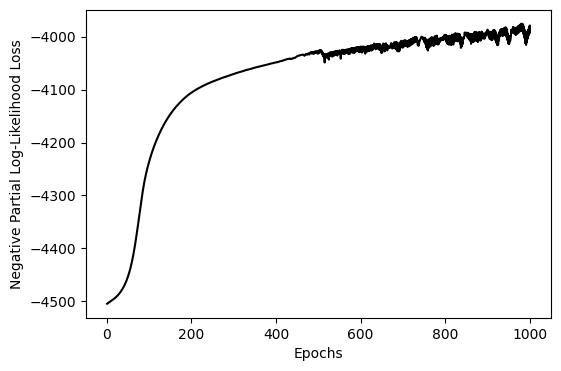

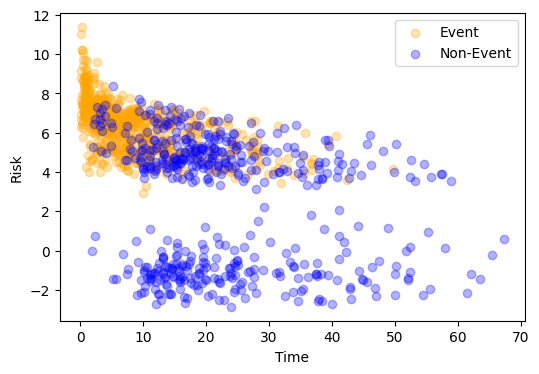

GNN[16, 32, 16, 1] 
- Loss: [-3979.258]
- Score: 0.8240431220223883


(array([-3979.258], dtype=float32), 0.8240431220223883)

In [74]:

cancer_architecture = [16, 32, 16, 1] # 7 input neurons, 2 hidden layers with 14 and 7 neurons, 1 output neuron
cancer_gnn = GNN(cancer_architecture)
test_nn(cancer_scaled, 'vital_status', 'OS', cancer_gnn, 0.0001, 1000, True)

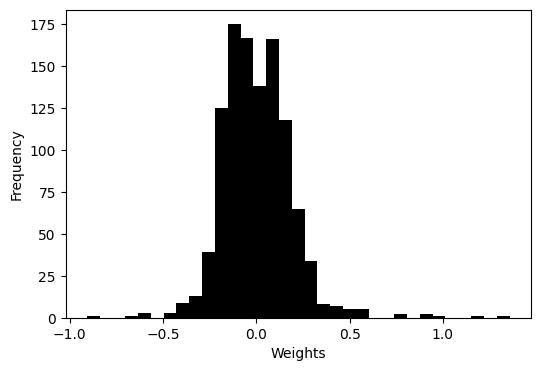

In [61]:
# Visualise weights of the GNN model using a histogram
# We expect there to be exponentially more weights in the GNN model than the SNN model
cancer_gnn.return_weights()

In [68]:
%pip install scikit-learn
from sklearn.mixture import GaussianMixture


class LCA:
    """Latent Class Analysis model for survival analysis."""
    
    def __init__(self, df, event, time, n_components=2, architecture=None):
        """Initialises the LCA model.

        Args:
            df (pandas.DataFrame): Dataframe containing the data.
            event (str): Name of the event column.
            time (str): Name of the time column.
            n_components (int, optional): Number of components in the Gaussian Mixture Model. Defaults to 2.
            architecture (torch.Tensor, optional): Architecture of the GNN model. Defaults to None.
        """
        self.components = n_components
        self.df = df
        self.event = event
        self.time = time
        
        # Initialise the covariates and the sizes
        # We take away 1 as we do not want to include the class, event and time variables
        self.input_size = len(self.df.columns) - 3
        
        # If the architecture is not None, we use the architecture provided
        if architecture is None:
            self.architecture = [self.input_size, 
                                 self.input_size + 1, np.sqrt(self.input_size + 1).astype(int) + 1,
                                 1]
        else:
            self.architecture = architecture
        # Initialise the models
        # We use GNNs as the models because they are more flexible than SNNs
        gnn = GNN(self.architecture)
        self.models = [gnn for _ in range(n_components)]
        # Initialise the Gaussian Mixture Model
        # We set the random state for reproducibility
        self.gmm = GaussianMixture(n_components=n_components, random_state=np.random.seed(42))
        
        # Stores dataframe for each latent class
        self.classes = []
        
        # Store risks for each each patient
        self.risks = []

    def fit(self):
        """Fits the LCA model to the dataset. and creates the seprate latent classes."""
        
        # Fit Gaussian Mixture Model to the dataset using Expectation Maximisation algorithm
        self.gmm.fit(self.df)
        
        # Assign patients to the latent classes
        self.df['LatentClass'] = self.gmm.predict(self.df)
    
    def train(self, lr=0.00001, epochs=1000, output=False):
        """Trains the GNN models for each latent class.
        
        Args:
            lr (float, optional): Learning rate. Defaults to 0.00001.
            epochs (int, optional): Number of epochs. Defaults to 1000.
            output (bool, optional): Whether to print the loss and output loss graph. Defaults to False.
        
        Returns:
            float: Total loss of the model.
        """  

        # Append the dataframes for each latent class to the classes list
        for i in range(self.components):
            self.classes.append(self.df.loc[self.df['LatentClass'] == i].drop('LatentClass', axis=1))
            # Remove the latent class column from the dataframe
            self.classes[i] = self.df.drop('LatentClass', axis=1)        
            
        # Initialise the total loss
        total_loss = 0
        
        # For each model, train the model on the data for the given latent class
        for i, model in enumerate(self.models):
            # Train the model of the latent class
            loss = train_model(self.classes[i], self.event, self.time, model, lr, epochs, output)
            print("Loss for latent class " + str(i) + ": " + str(loss.detach().numpy()))
            # Add the loss to the total loss (remember the loss is negative)
            total_loss += -loss
        
        return total_loss.detach().numpy()
    
    def predict(self):
        """Produces the predictions for each patient in the dataset and computes the final loss and Score."""

        classes = []
        # Iterate over all patients and compute the risk for each patient using the appropriate model
        for _, x in self.df.iterrows():
            latent_class = x['LatentClass']
            # Get the model for the patient
            model = self.models[int(latent_class)]
            # Remove LatentClass, time and event column from the patient data
            x = x.drop('LatentClass').drop(self.event).drop(self.time)
            # Make patient a tensor
            x = torch.tensor(x.to_numpy(), dtype=torch.float32)
            # Compute the risk for the patient
            with torch.no_grad():
                risk = model.forward(x)
            # Append the risk to the list of risks
            self.risks.append(risk)
            
        # Use the predicted risks to compute the score  
        return concordance_statistic(self.risks, self.df[self.event].to_numpy(), self.df[self.time].to_numpy(), True)

Note: you may need to restart the kernel to use updated packages.


In [69]:
def lca(df, event, time, n=2, architecture=None, lr=0.0001, epochs=1000, output=False):
    """Function to fit the LCA model and train the GNN models.

    Args:
        df (pandas.DataFrame): Dataframe containing the data
        event (str): Name of the event column
        time (str): Name of the time column
        n (int): Number of latent classes
        architecture (list, optional): Architecture of the GNN model. Defaults to None.
        lr (float, optional): Learning rate. Defaults to 0.0001.
        epochs (int, optional): Number of epochs. Defaults to 1000.
        output (bool, optional): Whether to print the loss and output loss graph. Defaults to False.

    Returns:
        LCA: Fitted LCA model.
    """
    X = df.copy()

    # Initialise LatentClass column as 0
    X['LatentClass'] = 0

    # Fits the LCA model
    model = LCA(X, event, time, n_components=n, architecture=architecture)
    model.fit()
    
    # Print the number of patients in each latent class
    print(model.df['LatentClass'].value_counts())
    
    # Trains the GNN models
    loss = model.train(lr, epochs, output)
    
    score = model.predict()
    
    print("Total Loss: {0} \nScore: {1}".format(loss, score))
    
    return model

0    1192
Name: LatentClass, dtype: int64
Loss for latent class 0: [-4033.6582]


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3273223497.py:23: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  risks = np.array(risks)[sorted_indices]
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3273223497.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  risks = np.array(risks)[sorted_indices]


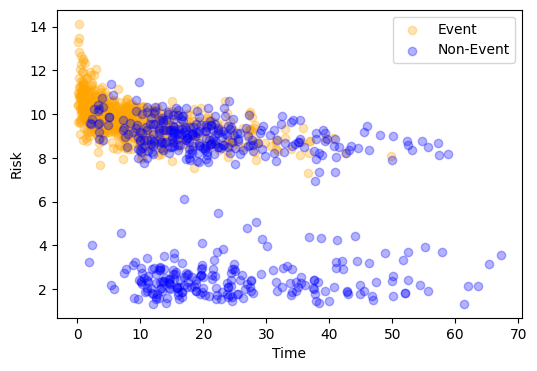

Total Loss: [4033.6582] 
Score: 0.8215519867039177


In [70]:
#This is just to confirm implemented properly

cancer_lca1 = lca(cancer_scaled, 'vital_status', 'OS', 1)

1    1046
0     146
Name: LatentClass, dtype: int64
Loss for latent class 0: [-4033.6582]
Loss for latent class 1: [-3957.9292]


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3273223497.py:23: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  risks = np.array(risks)[sorted_indices]
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3273223497.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  risks = np.array(risks)[sorted_indices]


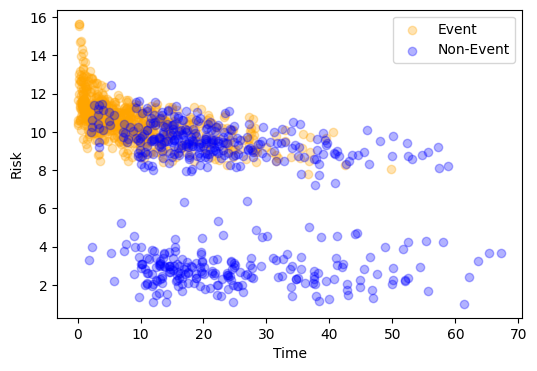

Total Loss: [7991.5874] 
Score: 0.8327197933391742


In [71]:
cancer_lca2 = lca(cancer_scaled, 'vital_status', 'OS', 2)

0    503
8    226
5    149
9    134
4     79
7     40
6     22
1     15
3     12
2     12
Name: LatentClass, dtype: int64
Loss for latent class 0: [-4033.6582]
Loss for latent class 1: [-3957.9292]
Loss for latent class 2: [-3954.948]
Loss for latent class 3: [-3938.995]
Loss for latent class 4: [-3926.2512]
Loss for latent class 5: [-3903.897]
Loss for latent class 6: [-3905.89]
Loss for latent class 7: [-3899.2036]
Loss for latent class 8: [-3898.384]
Loss for latent class 9: [-3893.1106]


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3273223497.py:23: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  risks = np.array(risks)[sorted_indices]
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3273223497.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  risks = np.array(risks)[sorted_indices]


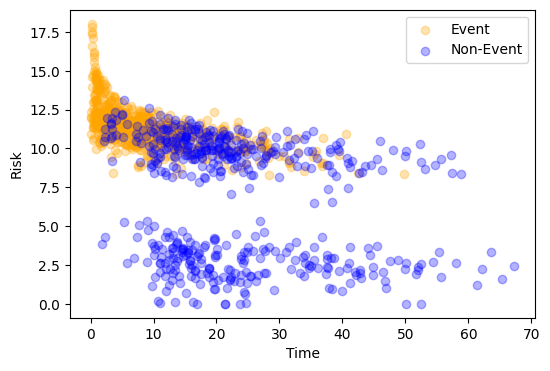

Total Loss: [39312.266] 
Score: 0.8426467325705133


In [89]:
cancer_lca2 = lca(cancer_scaled, 'vital_status', 'OS', 10)

4    494
1    391
0    191
2     57
3     46
5     13
Name: LatentClass, dtype: int64
Loss for latent class 0: [-3979.258]
Loss for latent class 1: [-3936.383]
Loss for latent class 2: [-3902.6096]
Loss for latent class 3: [-3891.9421]
Loss for latent class 4: [-3884.3428]
Loss for latent class 5: [-3845.6482]


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3273223497.py:23: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  risks = np.array(risks)[sorted_indices]
/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_24451/3273223497.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  risks = np.array(risks)[sorted_indices]


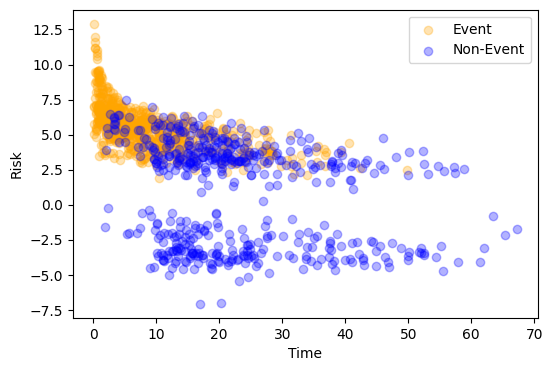

Total Loss: [23440.184] 
Score: 0.8488999522454059


In [75]:
cancer_lca6_arch = lca(cancer_scaled, 'vital_status', 'OS', 6, cancer_architecture)

In [ ]:

#This is something that I am trying

def tune_lca(df, event, time, max_components=10, architecture=None, lr=0.0001, epochs=1000, output=False):
    """Function to tune the LCA model by trying different numbers of latent classes.

    Args:
        df (pandas.DataFrame): Dataframe containing the data.
        event (str): Name of the event column.
        time (str): Name of the time column.
        max_components (int): Maximum number of latent classes to try.
        architecture (list, optional): Architecture of the GNN model. Defaults to None.
        lr (float, optional): Learning rate. Defaults to 0.0001.
        epochs (int, optional): Number of epochs. Defaults to 1000.
        output (bool, optional): Whether to print the loss and output loss graph. Defaults to False.

    Returns:
        dict: Dictionary containing the evaluation results for each number of latent classes.
    """
    evaluation_results = {}

    for n in range(1, max_components + 1):
        print(f"Trying {n} latent classes:")
        model = lca(df, event, time, n, architecture, lr, epochs, output)
        evaluation_results[n] = model.predict()

    return evaluation_results

# Example usage:
evaluation_results = tune_lca(cancer_scaled, 'vital_status', 'OS')
print(evaluation_results)


In [76]:

#THIS IS THE START OF THE CNN


# Create a simple CNN
class CNN(torch.nn.Module):
    """Simple CNN model for survival analysis."""
    def __init__(self, df, event, time, width=0, height=0):
        """Initialises the CNN model.
        
        Args:
            df (pandas.DataFrame): Dataframe containing the data
            event (str): Name of the event column
            time (str): Name of the time column
            width (int, optional): Width of the input image. Defaults to 0.
            height (int, optional): Height of the input image. Defaults to 0.
        """
        
        super(CNN, self).__init__()
        
        # Dataframe containing the data
        self.df = df
        
        # Event and time columns
        self.event = event
        self.time = time
                
        # Dataframe containing covariates
        self.dfx = self.df.drop([self.event, self.time], axis=1, inplace=False)
        # Convert dataframe to numpy array
        self.df_samples = self.dfx.to_numpy()
        
        # Calculate the optimal width and height based on the number of covariates
        # unless passed in
        if width == 0 or height == 0:
            self.width, self.height = self.get_optimal_dimensions(self.dfx.shape[1])
        else:
            self.width = width
            self.height = height
        
        # Use random seed for reproducibility
        torch.manual_seed(42)
        
        # Create the model
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(32 * (self.width // 2) * (self.height // 2), 128)
        self.fc2 = torch.nn.Linear(128, 1)
        self.layers = [self.conv1, self.pool, self.fc1, self.fc2]
        self.model = torch.nn.Sequential(*self.layers)
        
        # Transform the data
        self.transform()

    def forward(self, x):
        """Produces risk scores for the given patient image.

        Args:
            x (torch.Tensor): Patient image

        Returns:
            float: Risk score
        """
        
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = x.view(-1, 32 * (self.width // 2) * (self.height // 2))
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def transform(self):
        """Transforms the data to be used by the model."""
        
        # Convert features to images
        self.images = [self.features_to_image(x, self.width, self.height) for x in self.df_samples]
        
        # Prepare the data for the CNN
        self.tensors = [torch.tensor(image, dtype=torch.float32).unsqueeze(0) for image in self.images]
        self.tensor = torch.stack(self.tensors)
        self.labels = torch.tensor(self.df[self.event].to_numpy(), dtype=torch.float32).unsqueeze(1)

    def train(self, lr=0.0001, epochs=1000, output=True):
        """Trains the model.
        
        Args:
            lr (float): Learning rate
            epochs (int): Number of epochs
            output (bool, optional): Whether to output the loss plot. Defaults to True.
        """
        
        # Note we use a custom optimizer here as the original classes are not suitable
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        scores = []

        for _ in range(epochs):
            optimizer.zero_grad()

            # Forward pass
            outputs = self.forward(self.tensor)

            # Calculate concordance statistic
            score = concordance_statistic(outputs, self.df[self.event].to_numpy(), self.df[self.time].to_numpy(), output=False)

            # Calculate the negative of the concordance statistic to maximize it
            loss = -torch.tensor(score, requires_grad=True)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Save score
            scores.append(score)
            
        # Plot losses
        if output:
            plt.figure(figsize=(6, 4))
            plt.plot(scores)
            plt.xlabel('Epoch')
            plt.ylabel('Score')
            plt.show()
            
    def get_optimal_dimensions(self, n_features):
        """Calculate the optimal width and height for a given number of features.
        
        Args:
            n_features (int): Number of features
            
        Returns:
            tuple: Optimal width and height
        """
        
        sqrt_n_features = int(np.sqrt(n_features))
        if sqrt_n_features * sqrt_n_features == n_features:
            return sqrt_n_features, sqrt_n_features
        else:
            for i in range(sqrt_n_features + 1, n_features + 1):
                if n_features % i == 0:
                    return i, n_features // i
        
    # Convert features to images
    def features_to_image(self, features, width, height):
        """Converts features given a patient to an image.
        
        Args:
            features (np.array): Features of a patient
            width (int): Width of the image
            height (int): Height of the image
            
        Returns:
            np.array: Image of the features
        """
        
        # Normalize the features
        normalized_features = (features - np.min(features)) / (np.max(features) - np.min(features))

        # Calculate the required number of padding zeros
        num_features = len(features)
        target_size = width * height
        padding_zeros = target_size - num_features

        # If padding is required, add zeros to the features
        if padding_zeros > 0:
            normalized_features = np.concatenate((normalized_features, np.zeros(padding_zeros)))

        # Reshape the features to the desired width and height
        image = normalized_features.reshape(width, height)
        return image
        
    def return_weights(self):
        """Plots the weights in a histogram."""
        
        weights = []
        for layer in self.layers:
            if hasattr(layer, 'weight'):
                weights.append(layer.weight.view(-1))
                
        plot_weights(torch.cat(weights).detach().numpy())
        
    def plot_image(self, x):
        """Plots the feature image of a patient. Converts the image to an actual image.

        Args:
            x (int): Index of the patient in the dataframe.
        """
        plt.figure(figsize=(6, 4))
        plt.imshow(self.images[x], cmap='gray')
        plt.show()
        
    def score(self):
        return f"Score: {concordance_statistic(self(self.tensor).detach().numpy(), self.df[self.event].to_numpy(), self.df[self.time].to_numpy(), True)}"

16
5


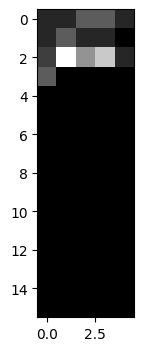

In [129]:
#I'm not sure yet what this does

cancer_cnn = CNN(cancer_scaled, 'vital_status', 'OS', 16, 5)
cancer_cnn.plot_image(0)

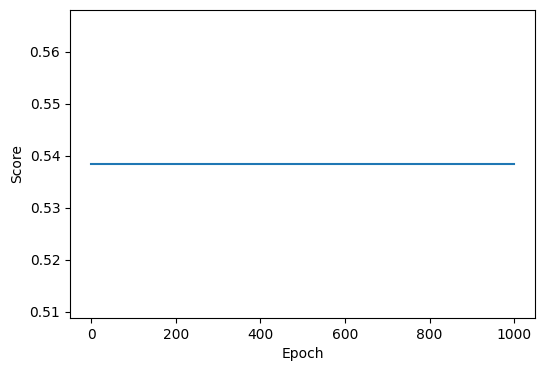

In [81]:
cancer_cnn.train()

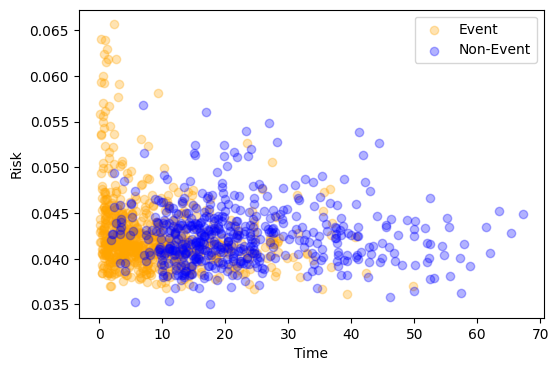

'Score: 0.5384349277852774'

In [82]:
cancer_cnn.score()

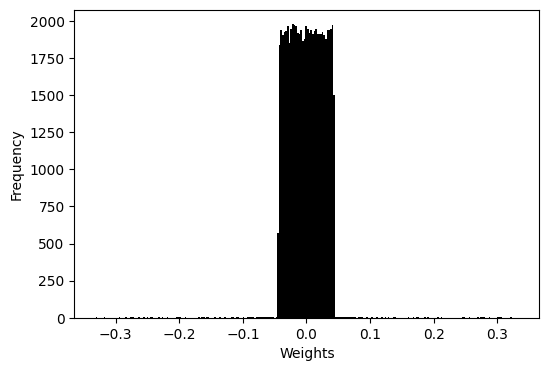

In [86]:
cancer_cnn.return_weights()

In [ ]:
#NOTE- interestingly, recategorized of categorical variables through ordinal encoding made the COX prediction worse. However
#The neural network approached similarity to cox model with ordinal coding and scaling. 

In [ ]:
#will do a subgroup analysis for GU only patients